# OVERBOUGHT / OVERSOLD ON SPREAD
***

Examine overbought / oversold on moving average token spreads as viable indicators.  
Given data is not split into training/testing sets, this is for **descriptive analysis only**.

To do:
- Add SPY data
- Calc coin MACD on variable days with RSI
- Calc coin OB/OS on MACD
- Summarize OB/OS on MACD
- Push data into S3 for better performance

Done:
- Get and parse coin data from Coin Metrics [Done]
- Calc coin SMA on variable trailing [Done]
- Calc coin OB/OS on SMA [Done]
- Summarize OS/OS on SMA [Done]

In [1]:
import glob 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 1. Data 
***

### 1.1. Tokens
Source: Coinmetrics community data as of Feb 1, 2023.  
Remove coins without reference rates and market cap.

In [2]:
# Check number of coins
all_tokens = glob.glob('/Users/zhi/projects/jupyter/lab/lumida/local/data/tokens/*.csv')

In [3]:
# Create dictionary of coin market data
coins_dict = dict()
for token in all_tokens:
    coin_name = token.split('/')[-1].split('.')[0]
    coins_dict[coin_name] = pd.read_csv(token, usecols=lambda x: x in ['time','ReferenceRateUSD', 'CapMrktCurUSD', 'CapMrktEstUSD'], parse_dates=['time'])
    
# Delete coins without at least price
coin_del = []
for coin in coins_dict.keys():
    if not {'ReferenceRateUSD'} <= set(coins_dict[coin].columns):
        coin_del.append(coin)

for coin in coin_del:
    coins_dict.pop(coin, None)

# Change current / estimated to just market cap, change reference rates to price
for coin in coins_dict.keys():
    if {'ReferenceRateUSD','CapMrktCurUSD'} <= set(coins_dict[coin].columns):
        coins_dict[coin] = coins_dict[coin].rename(columns={'ReferenceRateUSD':'price','CapMrktCurUSD':'cap'})
    elif {'ReferenceRateUSD','CapMrktEstUSD'} <= set(coins_dict[coin].columns):
        coins_dict[coin] = coins_dict[coin].rename(columns={'ReferenceRateUSD':'price','CapMrktEstUSD':'cap'})

# Create DataFrame of coin prices
coin_price = coins_dict['btc'].rename(columns={'price':'btc'})[['time','btc']]

coin_price.set_index('time',inplace=True)

for coin in coins_dict.keys():
    if not coin == 'btc':
        try:
            to_concat = coins_dict[coin].rename(columns={'price':coin})[['time',coin]]
            to_concat.set_index('time',inplace=True)
            coin_price = pd.concat([coin_price, to_concat],axis=1,join='outer')
        except KeyError:
            pass

coin_price = coin_price.fillna(method='ffill').fillna(0)

In [4]:
print(f'number of coins total: {len(all_tokens)}')
print(f'number of coins with price data: {len(coin_price.columns)}')

number of coins total: 583
number of coins with price data: 372


### 1.2. Equities Index
Source: WSJ market data.  
Note, WSJ data column headers have an empty space in front, hilarious

In [5]:
# Check number of indexes
all_indexes = glob.glob('/Users/zhi/projects/jupyter/lab/lumida/local/data/equities-indexes/*.csv')

In [6]:
index_dict = dict()
for index in all_indexes:
    index_name = index.split('/')[-1].split('.')[0]
    index_dict[index_name] = pd.read_csv(index, parse_dates=['Date'])

In [7]:
index_dict['spy'] = index_dict['spy'].sort_values(by='Date')

In [8]:
index_dict['spy'].set_index(['Date'], inplace=True)

## 2. Simple Moving Average Spread
***

### 2.1. Define Figures
1. Log Price
2. Spread 
3. Overbought table
4. Oversold table
5. Overbought summary performance
6. Oversold summary performance

In [9]:
# Figure 0: Price ------------------------------------------------

def plot_price(coin, trailing, start_date, end_date):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(
            x=coin_price[coin].loc[start_date:end_date].index,
            y=coin_price[coin].loc[start_date:end_date],
            name=coin,
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=index_dict['spy'].loc[start_date:end_date].index,
            y=index_dict['spy'].loc[start_date:end_date][' Open'],
            name='spy'
        ),
        secondary_y=True,

    )
    fig.update_layout(
        title={
            'text':'Price',
        },
    )  
    return fig

In [10]:
# Figure 1: COIN Log Price ------------------------------------------------

def plot_log_price(coin, trailing, start_date, end_date):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(
            x=coin_price[coin].loc[start_date:end_date].index,
            y=coin_price[coin].loc[start_date:end_date],
            name=coin,
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=index_dict['spy'].loc[start_date:end_date].index,
            y=index_dict['spy'].loc[start_date:end_date][' Open'],
            name='spy'
        ),
        secondary_y=True,

    )
    fig.update_yaxes(type='log', zeroline=True, zerolinecolor='rgba(255, 255, 255, 0.5)',)
    fig.update_layout(
        title={
            'text':'Log Price',
        },
    )  
    return fig

In [11]:
# Figure 2: COIN SMA Spread ------------------------------------------------

def plot_spread_price(coin, trailing, start_date, end_date):
    price_coin = coin_price[coin].loc[start_date:end_date]
    zscore_coin = (price_coin - price_coin.rolling(trailing).mean())/price_coin.rolling(trailing).std()
    
    price_index = index_dict['spy'].loc[start_date:end_date][' Open']
    zscore_index = (price_index - price_index.rolling(trailing).mean())/price_index.rolling(trailing).std()
    
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(
            x=coin_price[coin].loc[start_date:end_date].index,
            y=zscore_coin,
            name=f'{trailing}ma {coin}'
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=index_dict['spy'].loc[start_date:end_date].index,
            y=zscore_index,
            name=f'{trailing}ma spy'
        ),
        secondary_y=True,
    )
    fig.add_shape(type='rect',
                  x0=start_date,
                  y0=1,
                  x1=end_date,
                  y1=2,
                  line=dict(color='Red'),
                  fillcolor='red',
                  opacity=0.1,)
    fig.add_shape(type='rect',
                  x0=start_date,
                  y0=2,
                  x1=end_date,
                  y1=4,
                  line=dict(color='Red'),
                  fillcolor='red',
                  opacity=0.25,)
    fig.add_shape(type='rect',
                  x0=start_date,
                  y0=-1,
                  x1=end_date,
                  y1=-2,
                  line=dict(color='green'),
                  fillcolor='green',
                  opacity=0.1,)
    fig.add_shape(type='rect',
                  x0=start_date,
                  y0=-2,
                  x1=end_date,
                  y1=-4,
                  line=dict(color='green'),
                  fillcolor='green',
                  opacity=0.25,)
    fig.update_yaxes(
        range = [
            -4,4
            
        ]
    )
    fig.update_layout(
        title={
            'text': f'{trailing}ma spread {coin} + spy ',
        },
    )
    return fig
    

In [12]:
# Figure 3:COIN Overbought table ------------------------------------------------

def plot_table_overbought_coin(coin, trailing, start_date, end_date,rolling, obthreshold):    
	# coin price
    price = coin_price[coin].loc[start_date:end_date]
    # coin zscore all
    zscore = (price - price.rolling(trailing).mean())/price.rolling(trailing).std()
    # coin zscore trailing
    zscore_roll = zscore.rolling(rolling).mean()
	# event date
    zscore_threshold_date = zscore_roll[zscore_roll>=int(obthreshold)].index.date
	# event z score
    zscore_threshold_value = zscore_roll[zscore_roll>=int(obthreshold)].map('{:.1f}'.format)

	# set up for loop for table values
    days = [7, 30, 60, 90, 180, 360]
    column_headers = [
    	'Event Date',
	     f'{rolling} sma',
    ]
    values = [
		zscore_threshold_date,
		zscore_threshold_value,
    ]
    for day in days:
        ret = (coin_price[coin].pct_change(day).shift(-day).fillna(0)*100).map('{:.1f}'.format).loc[zscore_roll[zscore_roll>=int(obthreshold)].index]
        values.append(ret)
        column_headers.append(f'{day}d ret%')

	# plot the table
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=column_headers
                ),
                cells=dict(
                	values = values,
                 	font_size=10,
                )
            )
        ]
    )
    fig.update_layout(
        height=500,
        title={
            'text': f'Overbought on {rolling}ma zscore, {trailing}ma price, zscore >= {obthreshold}',
        },
    )
    return fig

In [13]:
# Figure 4: COIN Oversold table ------------------------------------------------

def plot_table_oversold_coin(coin, trailing, start_date, end_date,rolling, osthreshold):    
	# coin price
    price = coin_price[coin].loc[start_date:end_date]
    # coin zscore all
    zscore = (price - price.rolling(trailing).mean())/price.rolling(trailing).std()
    # coin zscore trailing
    zscore_roll = zscore.rolling(rolling).mean()
	# event date
    zscore_threshold_date = zscore_roll[zscore_roll<=int(osthreshold)].index.date
	# event z score
    zscore_threshold_value = zscore_roll[zscore_roll<=int(osthreshold)].map('{:.1f}'.format)

	# set up for loop for table values
    days = [7, 30, 60, 90, 180, 360]
    column_headers = [
    	'Event Date',
	     f'{rolling} sma',
    ]
    values = [
		zscore_threshold_date,
		zscore_threshold_value,
    ]
    for day in days:
        ret = (coin_price[coin].pct_change(day).shift(-day).fillna(0)*100).map('{:.1f}'.format).loc[zscore_roll[zscore_roll<=int(osthreshold)].index]
        values.append(ret)
        column_headers.append(f'{day}d ret%')

	# plot the table
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=column_headers
                ),
                cells=dict(
                	values = values,
                 	font_size=10,
                )
            )
        ]
    )
    fig.update_layout(
        height=500,
        title={
            'text': f'Oversold on {rolling}ma zscore, {trailing}ma price, zscore <= {osthreshold}',
        },
    )
    return fig


In [14]:
# Figure 5:COIN Overbought SUMMARY -------------------------------

def plot_table_overbought_coin_summary(coin, trailing, start_date, end_date,rolling, obthreshold):    
    price = coin_price[coin].loc[start_date:end_date]
    
    zscore = (price - price.rolling(trailing).mean())/price.rolling(trailing).std()
    
    zscore_roll = zscore.rolling(rolling).mean()
    
    days = [7, 30, 60, 90, 180, 360]

    column_headers = [' ',]
    
    values=[
    # 1st col
        [
        'Mean Returns',
        'Median Returns',
        'Count of Ups',
        'Count of Downs',
        'All Mean Returns'
        ]
    ]
    
    for day in days:
        ret = (coin_price[coin].pct_change(day).shift(-day).fillna(0)*100).loc[zscore_roll[zscore_roll>=int(obthreshold)].index]

        mean = "{:.2f}".format(ret.mean())

        median = "{:.2f}".format(ret.median())

        number_up = ret[ret>0].count()

        number_down = ret[ret<0].count()

        all_mean = "{:.2f}".format(coin_price[coin].loc[start_date:end_date].pct_change(day).shift(-day).mean())
    
        values.append([mean, median, number_up, number_down, all_mean])
        column_headers.append(f'{day}d ret%')
    
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=column_headers
                ),
                cells=dict(
                    values=values,
#                     fill_color=[
                        
#                     ]
                )
            )
        ]
    )
    fig.update_layout(
        title={
            'text': f'SUMMARY Overbought on {rolling}ma zscore, {trailing}ma price, zscore >= {obthreshold}',
        },
    )
    return fig


In [15]:
# Figure 6:COIN Oversold SUMMARY -------------------------------

def plot_table_oversold_coin_summary(coin, trailing, start_date, end_date,rolling, osthreshold):    
    price = coin_price[coin].loc[start_date:end_date]
    
    zscore = (price - price.rolling(trailing).mean())/price.rolling(trailing).std()
    
    zscore_roll = zscore.rolling(rolling).mean()
    
    days = [7, 30, 60, 90, 180, 360]

    column_headers = [' ',]
    
    values=[
    # 1st col
        [
        'Mean Returns',
        'Median Returns',
        'Count of Ups',
        'Count of Downs',
        'All Mean Returns'
        ]
    ]
    
    for day in days:
        ret = (coin_price[coin].pct_change(day).shift(-day).fillna(0)*100).loc[zscore_roll[zscore_roll<=int(osthreshold)].index]

        mean = "{:.2f}".format(ret.mean())

        median = "{:.2f}".format(ret.median())

        number_up = ret[ret>0].count()

        number_down = ret[ret<0].count()

        all_mean = "{:.2f}".format(coin_price[coin].loc[start_date:end_date].pct_change(day).shift(-day).mean())
    
        values.append([mean, median, number_up, number_down, all_mean])
        column_headers.append(f'{day}d ret%')
    
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=column_headers
                ),
                cells=dict(
                    values=values
#                     fill_color=[
                        
#                     ]
                )
            )
        ]
    )
    fig.update_layout(
        title={
            'text': f'SUMMARY Oversold on {rolling}ma zscore, {trailing}ma price, zscore <= {osthreshold}',
        },
    )
    return fig


In [68]:
# Figure 7 : Correlations Plot
def plot_correlation(coin, trailing, start_date, end_date, rolling):
    df = pd.concat([coin_price[coin].loc[start_date:end_date].pct_change(), index_dict['spy'].loc[start_date:end_date][' Open'].pct_change()], join="outer", axis=1)
    df = df.fillna(method='ffill').fillna(method='bfill')
    df = df.rename(columns={' Open': 'spy'})
    dfcorr = df[coin].rolling(trailing).corr(df['spy'])
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=dfcorr.index,
            y=dfcorr,
            name=f'{trailing} corr',
        )
    )
    fig.update_layout(
        title={
            'text': f'{coin} + spy Correlation {trailing}d',
        },
    )
    return fig

### 2.2 Set Parameters

In [69]:
# adjust these parameters
coin = 'btc'
start_date = '2011-01-01' #adjust this according to coin e.g. set to 2017 for 'eth'
end_date = '2023-01-29'
trailing = 360
rolling = 5
obthreshold = 3
osthreshold = -3

# *** do not edit below ***************************************************************************************************
fig_price = plot_price(coin, trailing, start_date, end_date)
fig_log = plot_log_price(coin, trailing, start_date, end_date)
fig_spread = plot_spread_price(coin, trailing, start_date, end_date)
fig_corr = plot_correlation(coin, trailing, start_date, end_date, rolling)
table_ob = plot_table_overbought_coin(coin, trailing, start_date, end_date,rolling, obthreshold)    
table_os = plot_table_oversold_coin(coin, trailing, start_date, end_date,rolling, osthreshold)    
table_ob_summary = plot_table_overbought_coin_summary(coin, trailing, start_date, end_date,rolling, obthreshold)    
table_os_summary = plot_table_oversold_coin_summary(coin, trailing, start_date, end_date,rolling, osthreshold)    

# COMMENT OUT FOR INTERACTIVE PLOTS (not avaliable over static HTML)
# fig_price.show()
# fig_log.show()
# fig_spread.show()
# fig_corr.show()
# table_ob.show()
# table_os.show()
# table_ob_summary.show()
# table_os_summary.show()

In [54]:
# for static html plots pngs
from IPython.display import Image
import plotly.io as pio
pio.kaleido.scope.default_format = "png"
pio.kaleido.scope.default_width = "1280"
pio.kaleido.scope.default_height = "720"
pio.kaleido.scope.default_scale = "2"

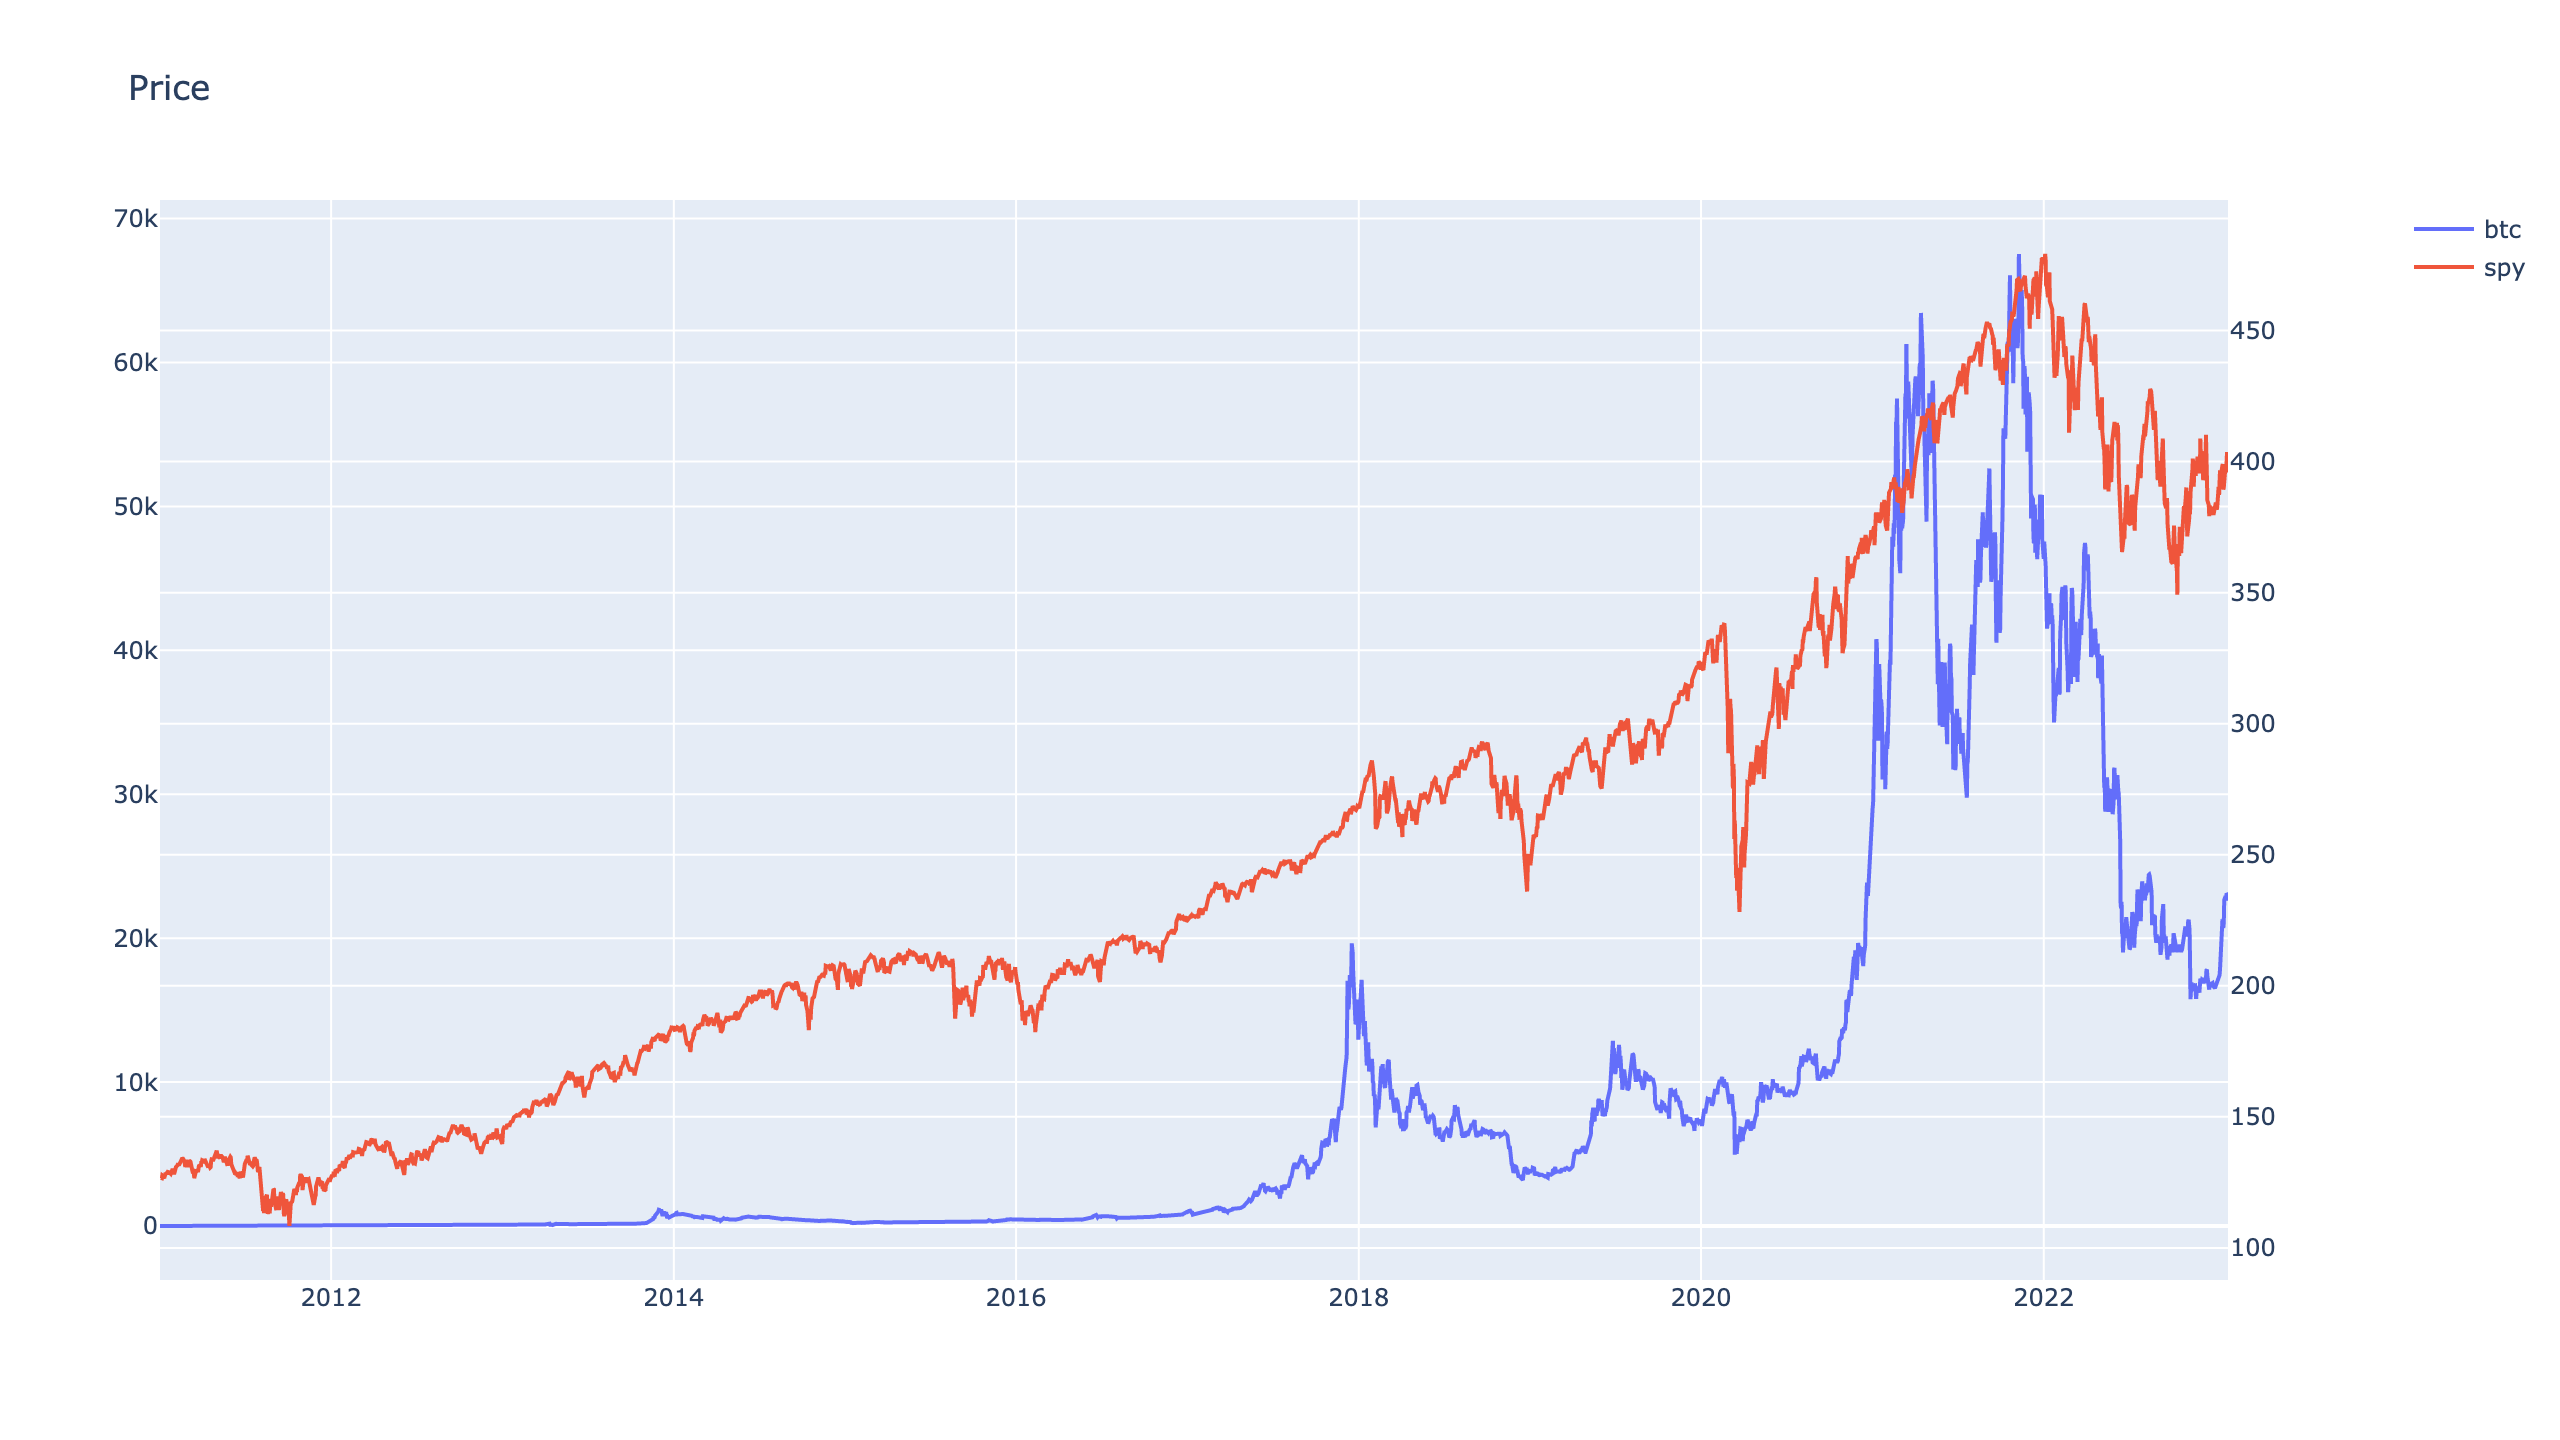

In [64]:
Image(fig_price.to_image())

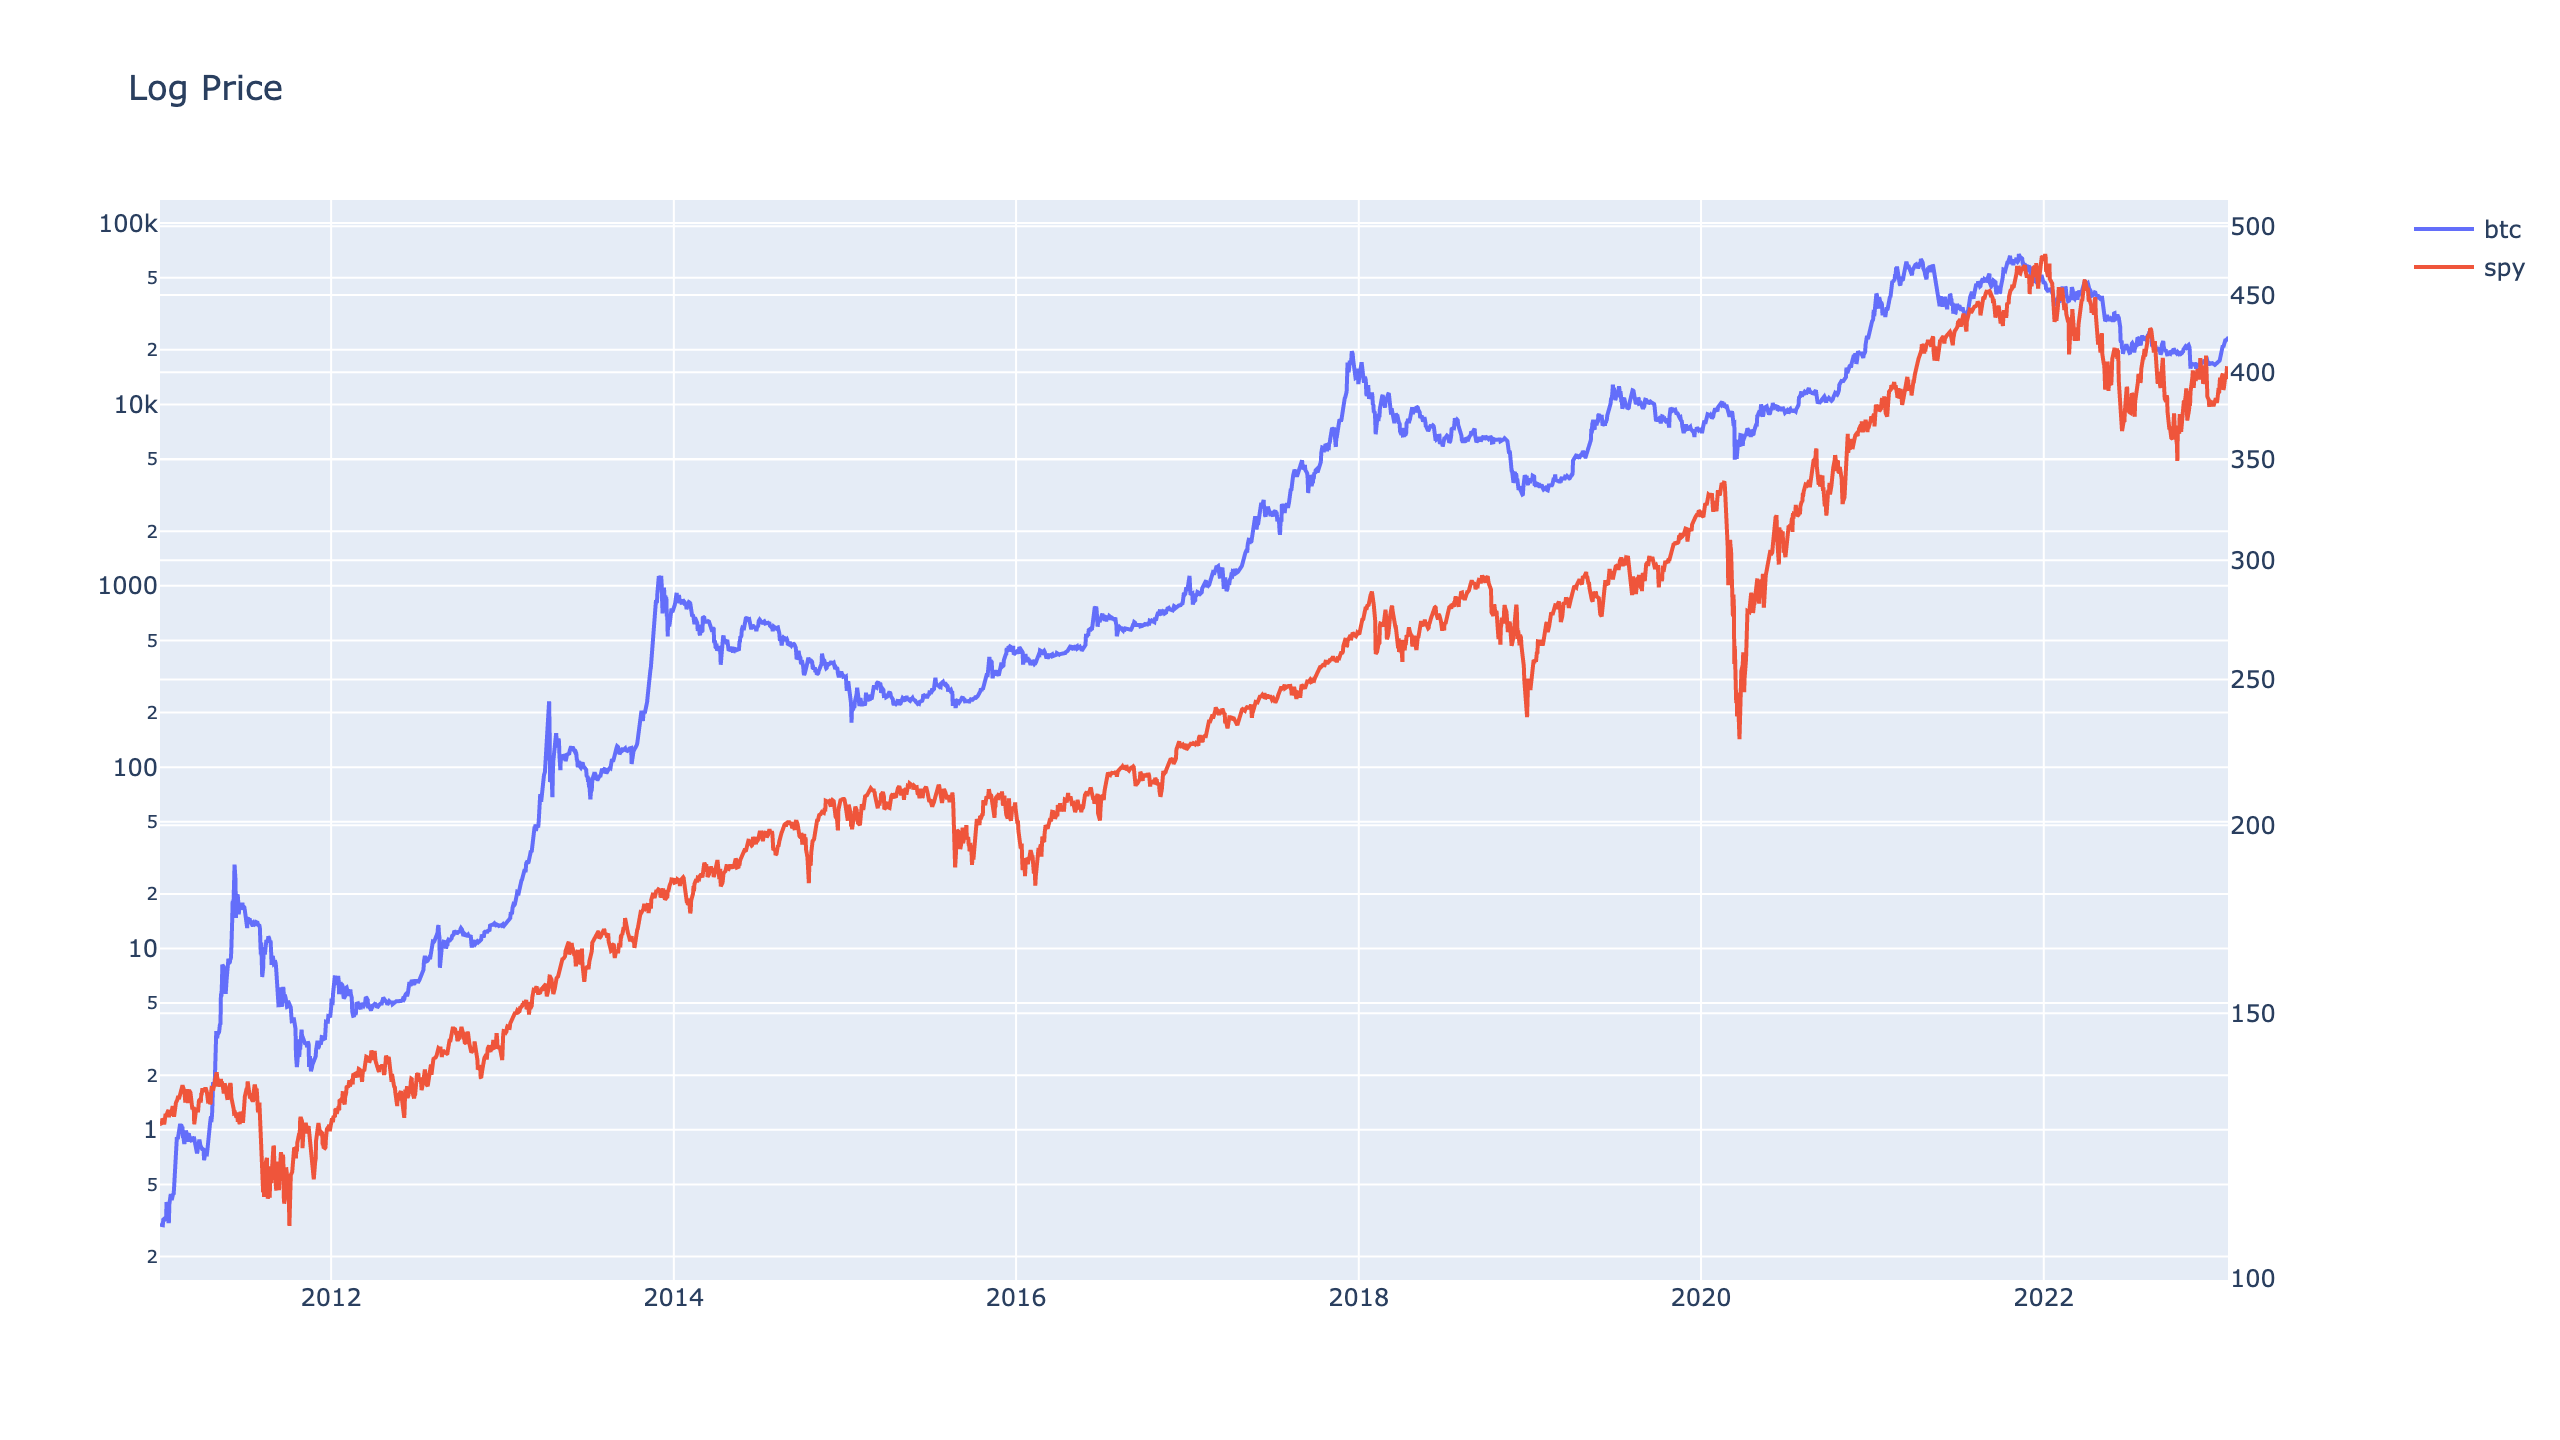

In [65]:
Image(fig_log.to_image())

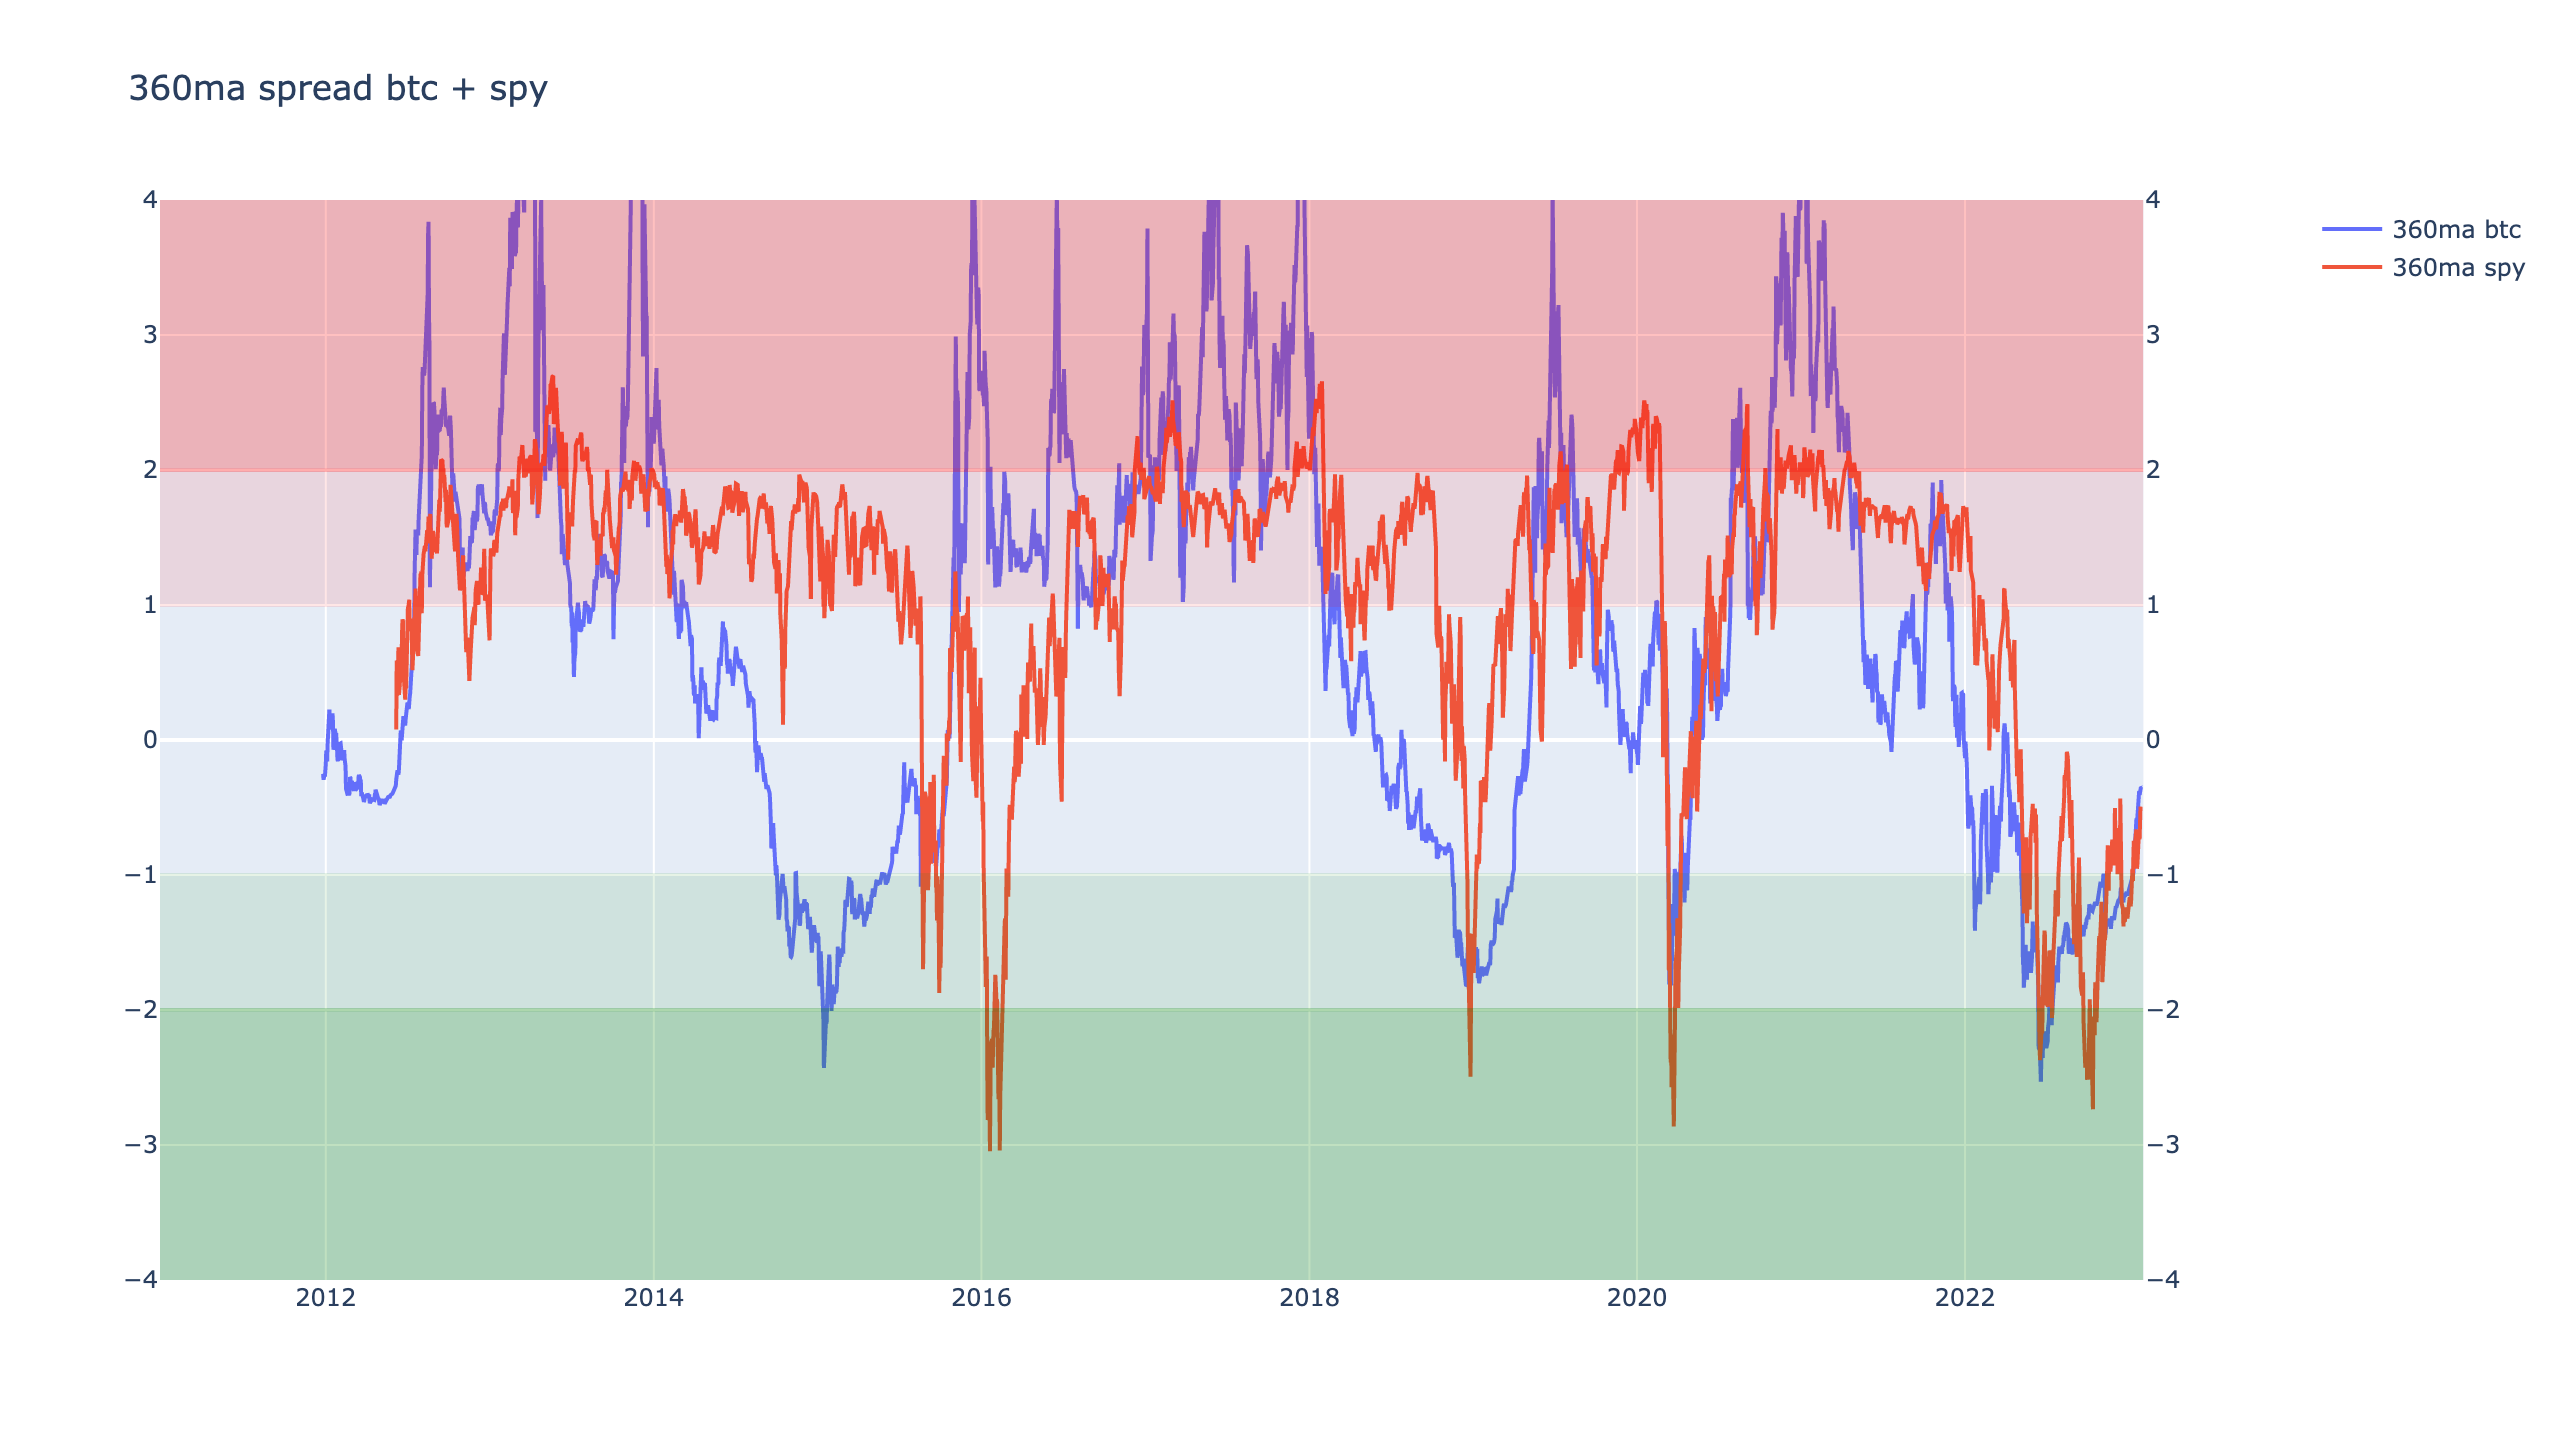

In [66]:
Image(fig_spread.to_image())

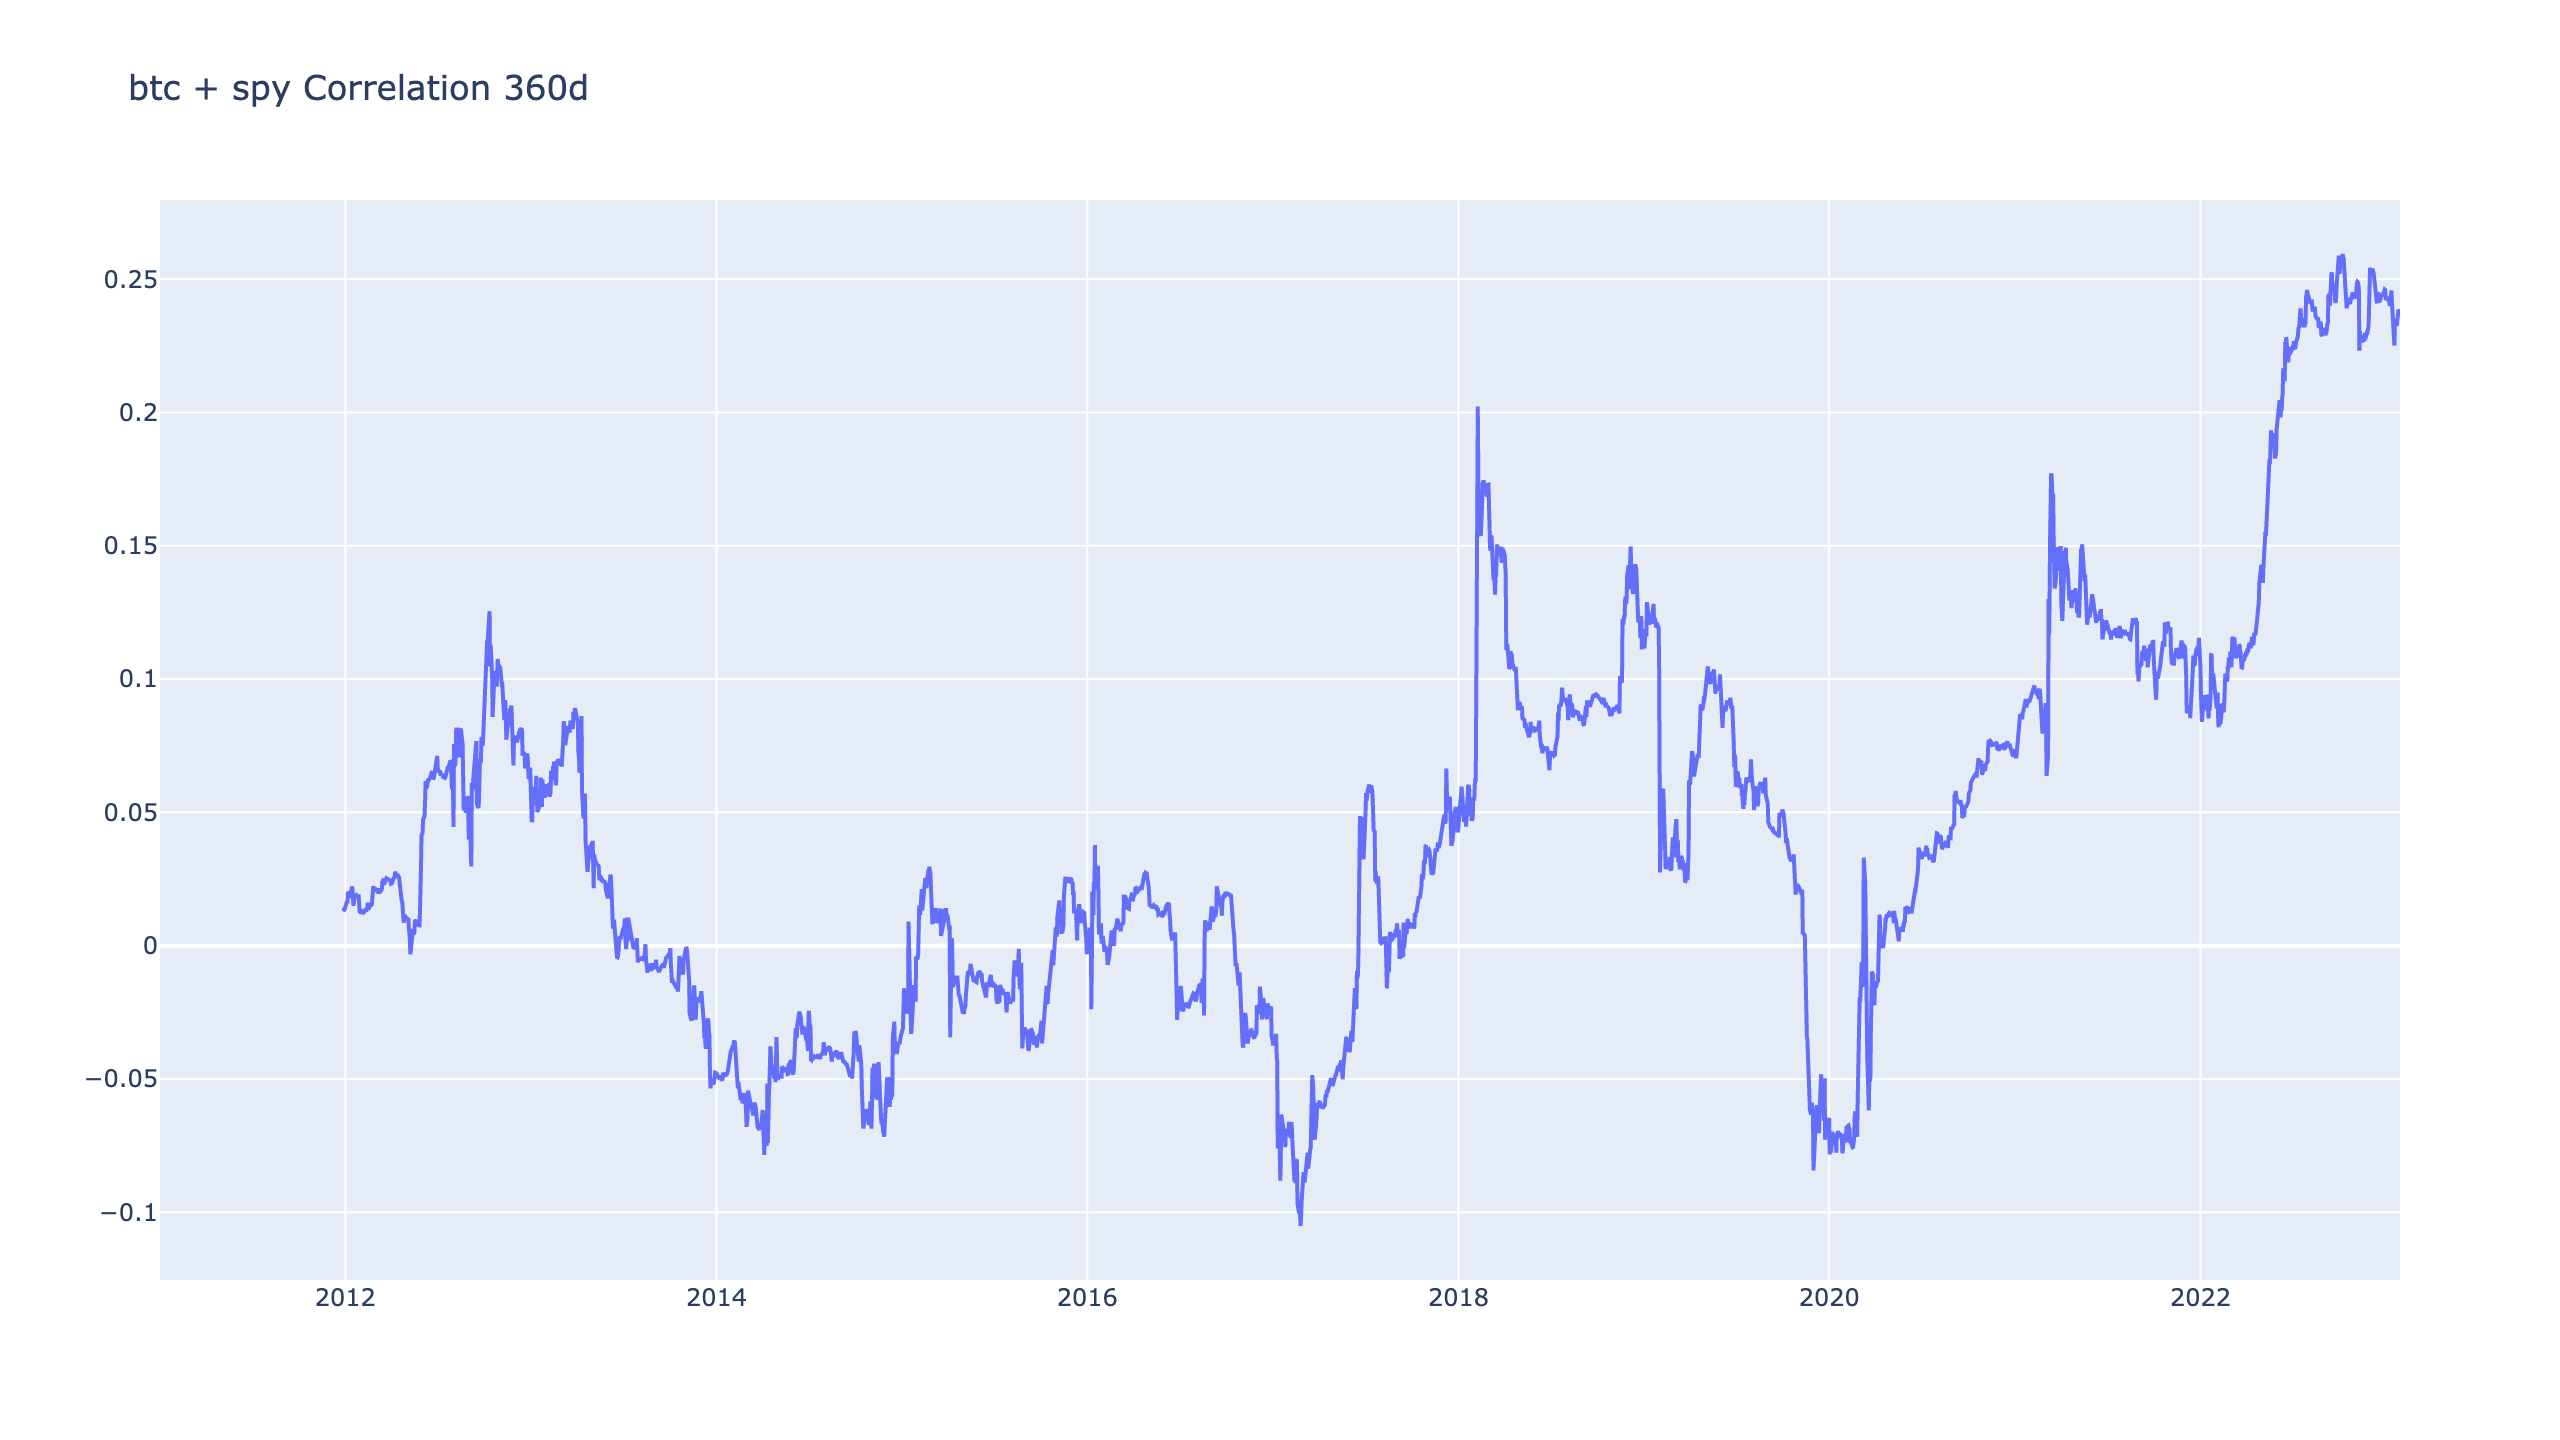

In [70]:
Image(fig_corr.to_image())

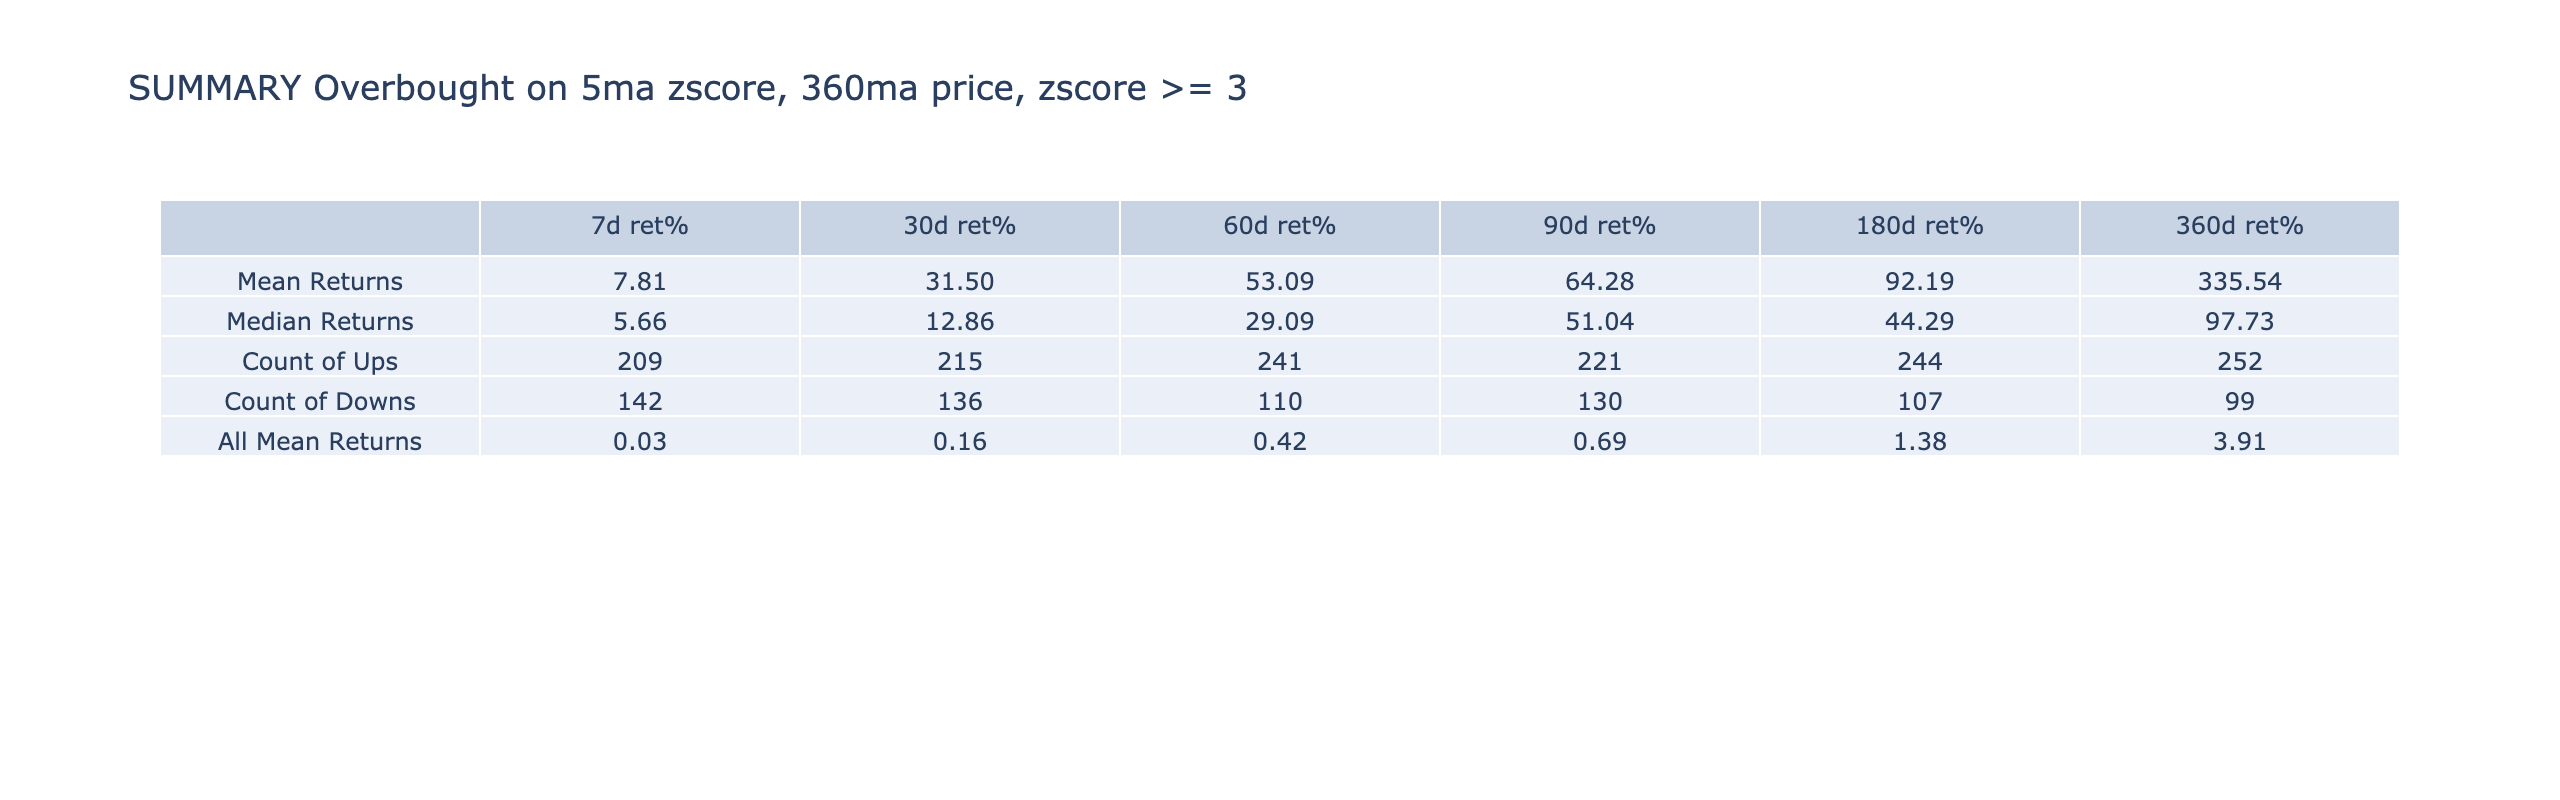

In [81]:
Image(table_ob_summary.to_image(height='400'))

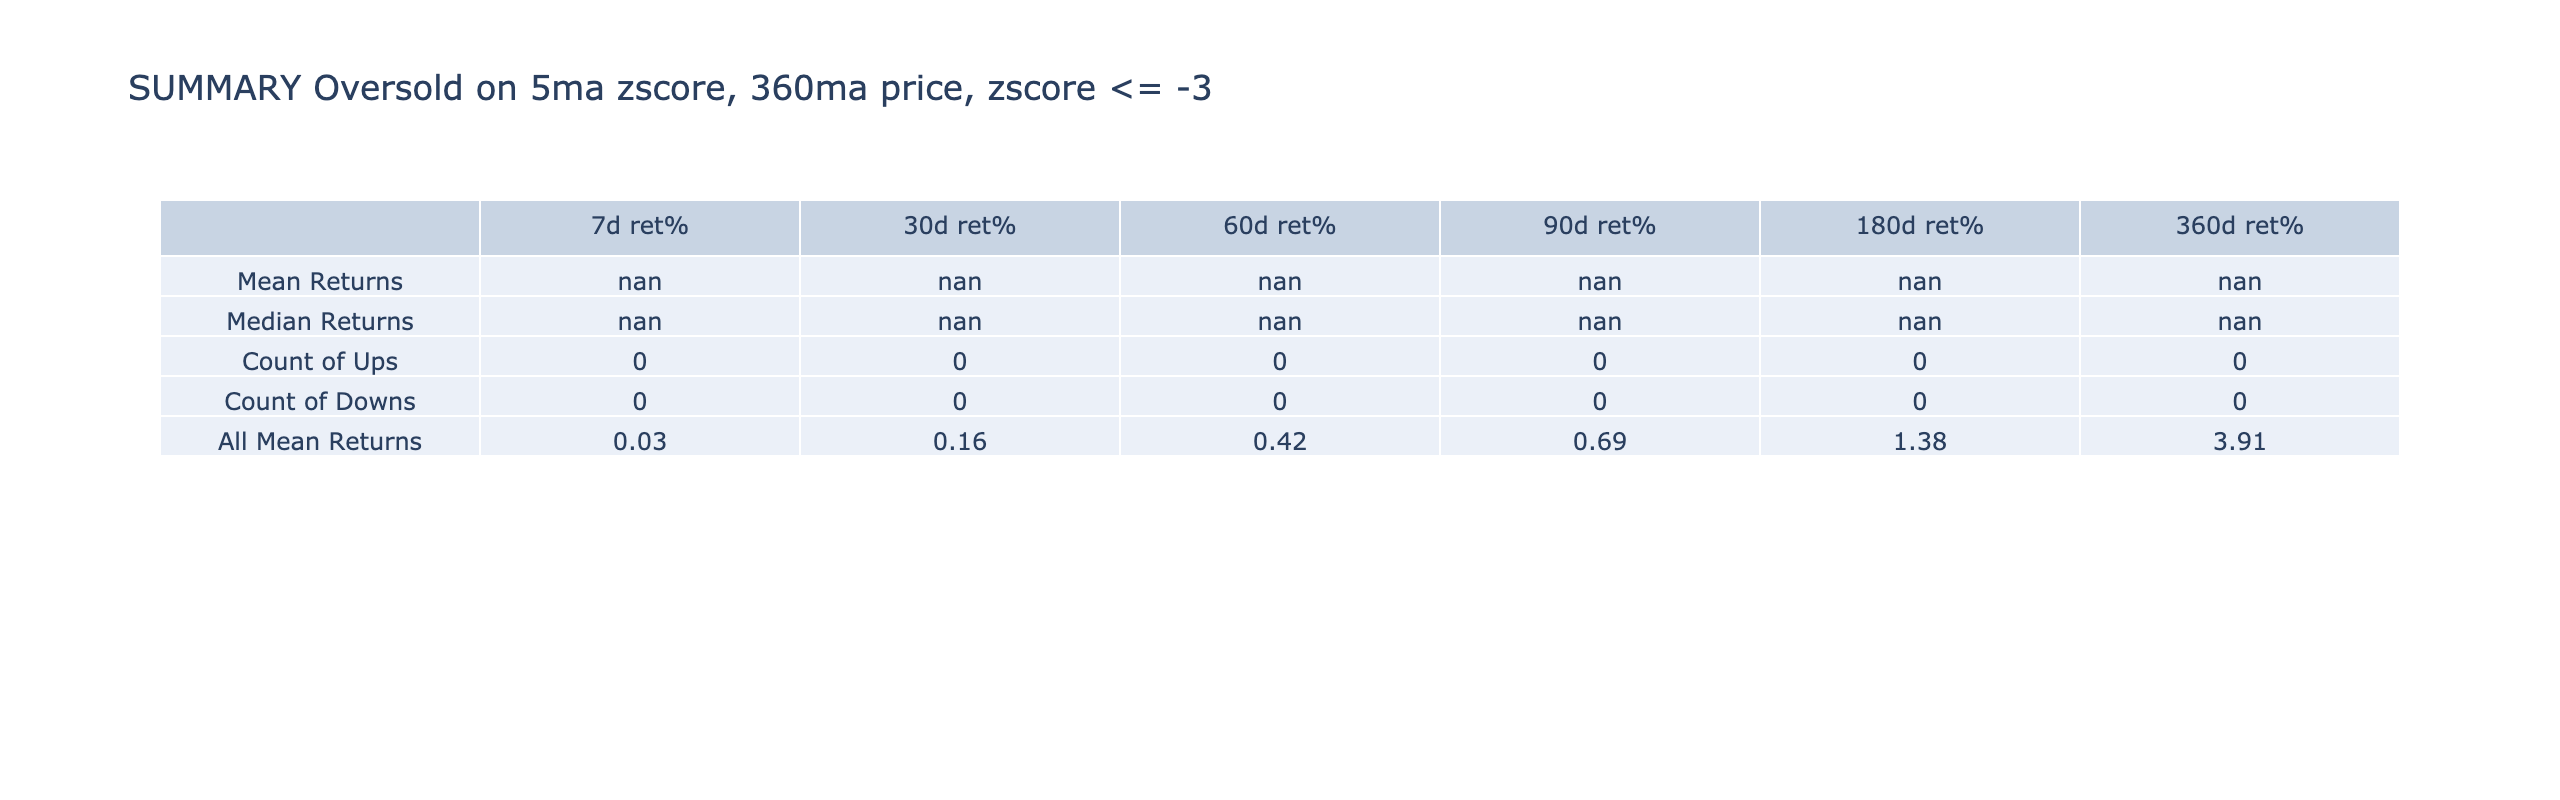

In [83]:
Image(table_os_summary.to_image(height='400'))

## 3. Moving Average Convergence / Divergence (MACD)
***

MACD Logic:  
- MACD line = 12d price EMA - 26d price EMA
- Signal line = 9d MACD EMA
- Long: MACD line - Signal line > 0
- Short: MACD line - signal line < 0

EMA logic:
- EMA(n) = price(n)x(smoothing/days(n)) + EMA(n-1)x(1-(smoothing/days(n)))

To do:
- iterate over varying 12/26 to optimize for btc
- iterate over trailing for signal line

### 3.1. MACD with SMA

#### 3.1.1. Create Figures

In [18]:
# Figure 1: MACD SMA Coin ------------------------------------------------

def plot_macd_sma(coin, macd1ma, macd2ma, signalma, start_date, end_date):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    sma12 = coin_price[coin].rolling(macd1ma).mean().fillna(0).loc[start_date:end_date]
    sma26 = coin_price[coin].rolling(macd2ma).mean().fillna(0).loc[start_date:end_date]
    macd_sma = sma12 - sma26
    macd_sma_signal = macd_sma.rolling(signalma).mean().fillna(0)
    macd_sma_cross = macd_sma - macd_sma_signal

    macd_sma_over = macd_sma_cross[macd_sma_cross>0]
    macd_sma_under = macd_sma_cross[macd_sma_cross<0]
    
    
    # fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=coin_price[coin].loc[start_date:end_date].index,
            y=coin_price[coin].loc[start_date:end_date],
            name=f'{coin} price',
            line=dict(width=1),
            opacity=0.9,
        ),
        secondary_y=True,
        
    )
    fig.add_trace(
        go.Bar(
            x=macd_sma_under.index,
            y=macd_sma_under,
            name=f'{coin} MACD SMA under',
        ),
        secondary_y=False,

    )
    fig.add_trace(
        go.Bar(
            x=macd_sma_over.index,
            y=macd_sma_over,
            name=f'{coin} MACD SMA over',
        ),
        secondary_y=False,

    )
    fig.add_trace(
        go.Scatter(
            x=macd_sma.index,
            y=macd_sma,
            name=f'{coin} MACD SMA 12d/26d',
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=macd_sma_signal.index,
            y=macd_sma_signal,
            name=f'{coin} MACD SMA signal',
        ),
        secondary_y=False,

    )
    fig.update_layout(
        title={
            'text':f'{coin} MACD SMA {macd1ma}d/{macd2ma}d cross {signalma}d signal - {start_date} to {end_date}',
        },
    )  
    return fig

In [19]:
# Figure 3:macd sma cross overtable ------------------------------------------------

def plot_table_macd_sma_returns(coin, macd1ma, macd2ma, signalma, start_date, end_date):
    
    sma12 = coin_price[coin].rolling(macd1ma).mean().fillna(0).loc[start_date:end_date]
    sma26 = coin_price[coin].rolling(macd2ma).mean().fillna(0).loc[start_date:end_date]
    macd_sma = sma12 - sma26
    macd_sma_signal = macd_sma.rolling(signalma).mean().fillna(0)
    macd_sma_cross = macd_sma - macd_sma_signal
    
    cross_trigger = macd_sma_cross.shift(1)/macd_sma_cross
    cross_dates = [pd.to_datetime(start_date)] + list(cross_trigger[cross_trigger<0].index) + [pd.to_datetime(end_date)]
    
    # get signal on day n, implement trade day after n+1
    ret = []
    for i in range(0,len(cross_dates)-1):
        cross_start = cross_dates[i] + pd.Timedelta(1, unit='D')
        cross_end = cross_dates[i+1]
        if macd_sma_cross.loc[cross_dates[i]] > 0:
            ret.append((coin_price['btc'].loc[cross_end]/coin_price['btc'].loc[cross_start] - 1))
        else:
            ret.append((-(coin_price['btc'].loc[cross_end]/coin_price['btc'].loc[cross_start] - 1)))
        # if macd_sma_cross.loc[cross_start] > 0:
        #     ret.append("{:.2f}%".format((coin_price['btc'].loc[cross_end]/coin_price['btc'].loc[cross_start] - 1)*100))
        # else:
        #     ret.append("{:.2f}%".format((-(coin_price['btc'].loc[cross_end]/coin_price['btc'].loc[cross_start] - 1))*100))

    # set up table
    column_headers = [
    	'Cross value',
    	'Cross Start',
    	# 'Cross End',
    	# 'Days',
        'Returns',
        # 'Volatility',
        # 'Sharpe',
    ]
    values = [
		macd_sma_cross.loc[cross_dates],
        macd_sma_cross.loc[cross_dates].index.date,
        ret,
    ]


	# plot the table
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=column_headers
                ),
                cells=dict(
                	values = values,
                 	font_size=10,
                )
            )
        ]
    )
    fig.update_layout(
        height=500,
        title={
            'text': f'MACD Returns',
        },
    )
    return fig, ret


In [20]:
def plot_macd_sma_eqv(coin, macd1ma, macd2ma, signalma, start_date, end_date):
    
    sma12 = coin_price[coin].rolling(macd1ma).mean().fillna(0).loc[start_date:end_date]
    sma26 = coin_price[coin].rolling(macd2ma).mean().fillna(0).loc[start_date:end_date]
    macd_sma = sma12 - sma26
    macd_sma_signal = macd_sma.rolling(signalma).mean().fillna(0)
    macd_sma_cross = macd_sma - macd_sma_signal
    
    cross_trigger = macd_sma_cross.shift(1)/macd_sma_cross
    cross_dates = [pd.to_datetime(start_date)] + list(cross_trigger[cross_trigger<0].index) + [pd.to_datetime(end_date)]
    
    eq_btc= 100
    eq_btc_ts = []
    for ret in (coin_price[coin].pct_change(1)+1).loc[start_date:end_date]:
        eq_btc = eq_btc*ret
        eq_btc_ts.append(eq_btc)
    
    eq_macd_sma = 100
    eq_macd_sma_ts = []
    for ret in [x+1 for x in eq_macd_sma_ret]:
        eq_macd_sma = eq_macd_sma*ret
        eq_macd_sma_ts.append(eq_macd_sma)
    
    fig = go.Figure()
    
    # fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=coin_price[coin].loc[start_date:end_date].index,
            y=eq_btc_ts[:-1],
            name=f'{coin} eqv',
        ),        
    )
    fig.add_trace(
        go.Scatter(
            x=macd_sma_cross.loc[cross_dates].index[:-1],
            y=eq_macd_sma_ts,
            name=f'{coin} MACD SMA eqv',
        ),
    )
    fig.update_layout(
        title={
            'text':'Equity Value of MACD vs Holding',
        },
    )  
    return fig



#### 3.1.2. MACD SMA Parameters

In [29]:
macd1ma = 12
macd2ma = 26
signalma = 9
coin = 'btc'
start_date = '2022-01-29'
end_date = '2023-01-29'

fig_macd_sma = plot_macd_sma(coin, macd1ma, macd2ma, signalma, start_date, end_date)
fig_macd_sma_ret, eq_macd_sma_ret =  plot_table_macd_sma_returns(coin, macd1ma, macd2ma, signalma, start_date, end_date)
fig_eqv =  plot_macd_sma_eqv(coin, macd1ma, macd2ma, signalma, start_date, end_date)

# COMMENT OUT FOR INTERACTIVE PLOTS (not avaliable over static html)
# fig_macd_sma.show()
# fig_eqv.show()
# fig_macd_sma_ret.show()


Static images:

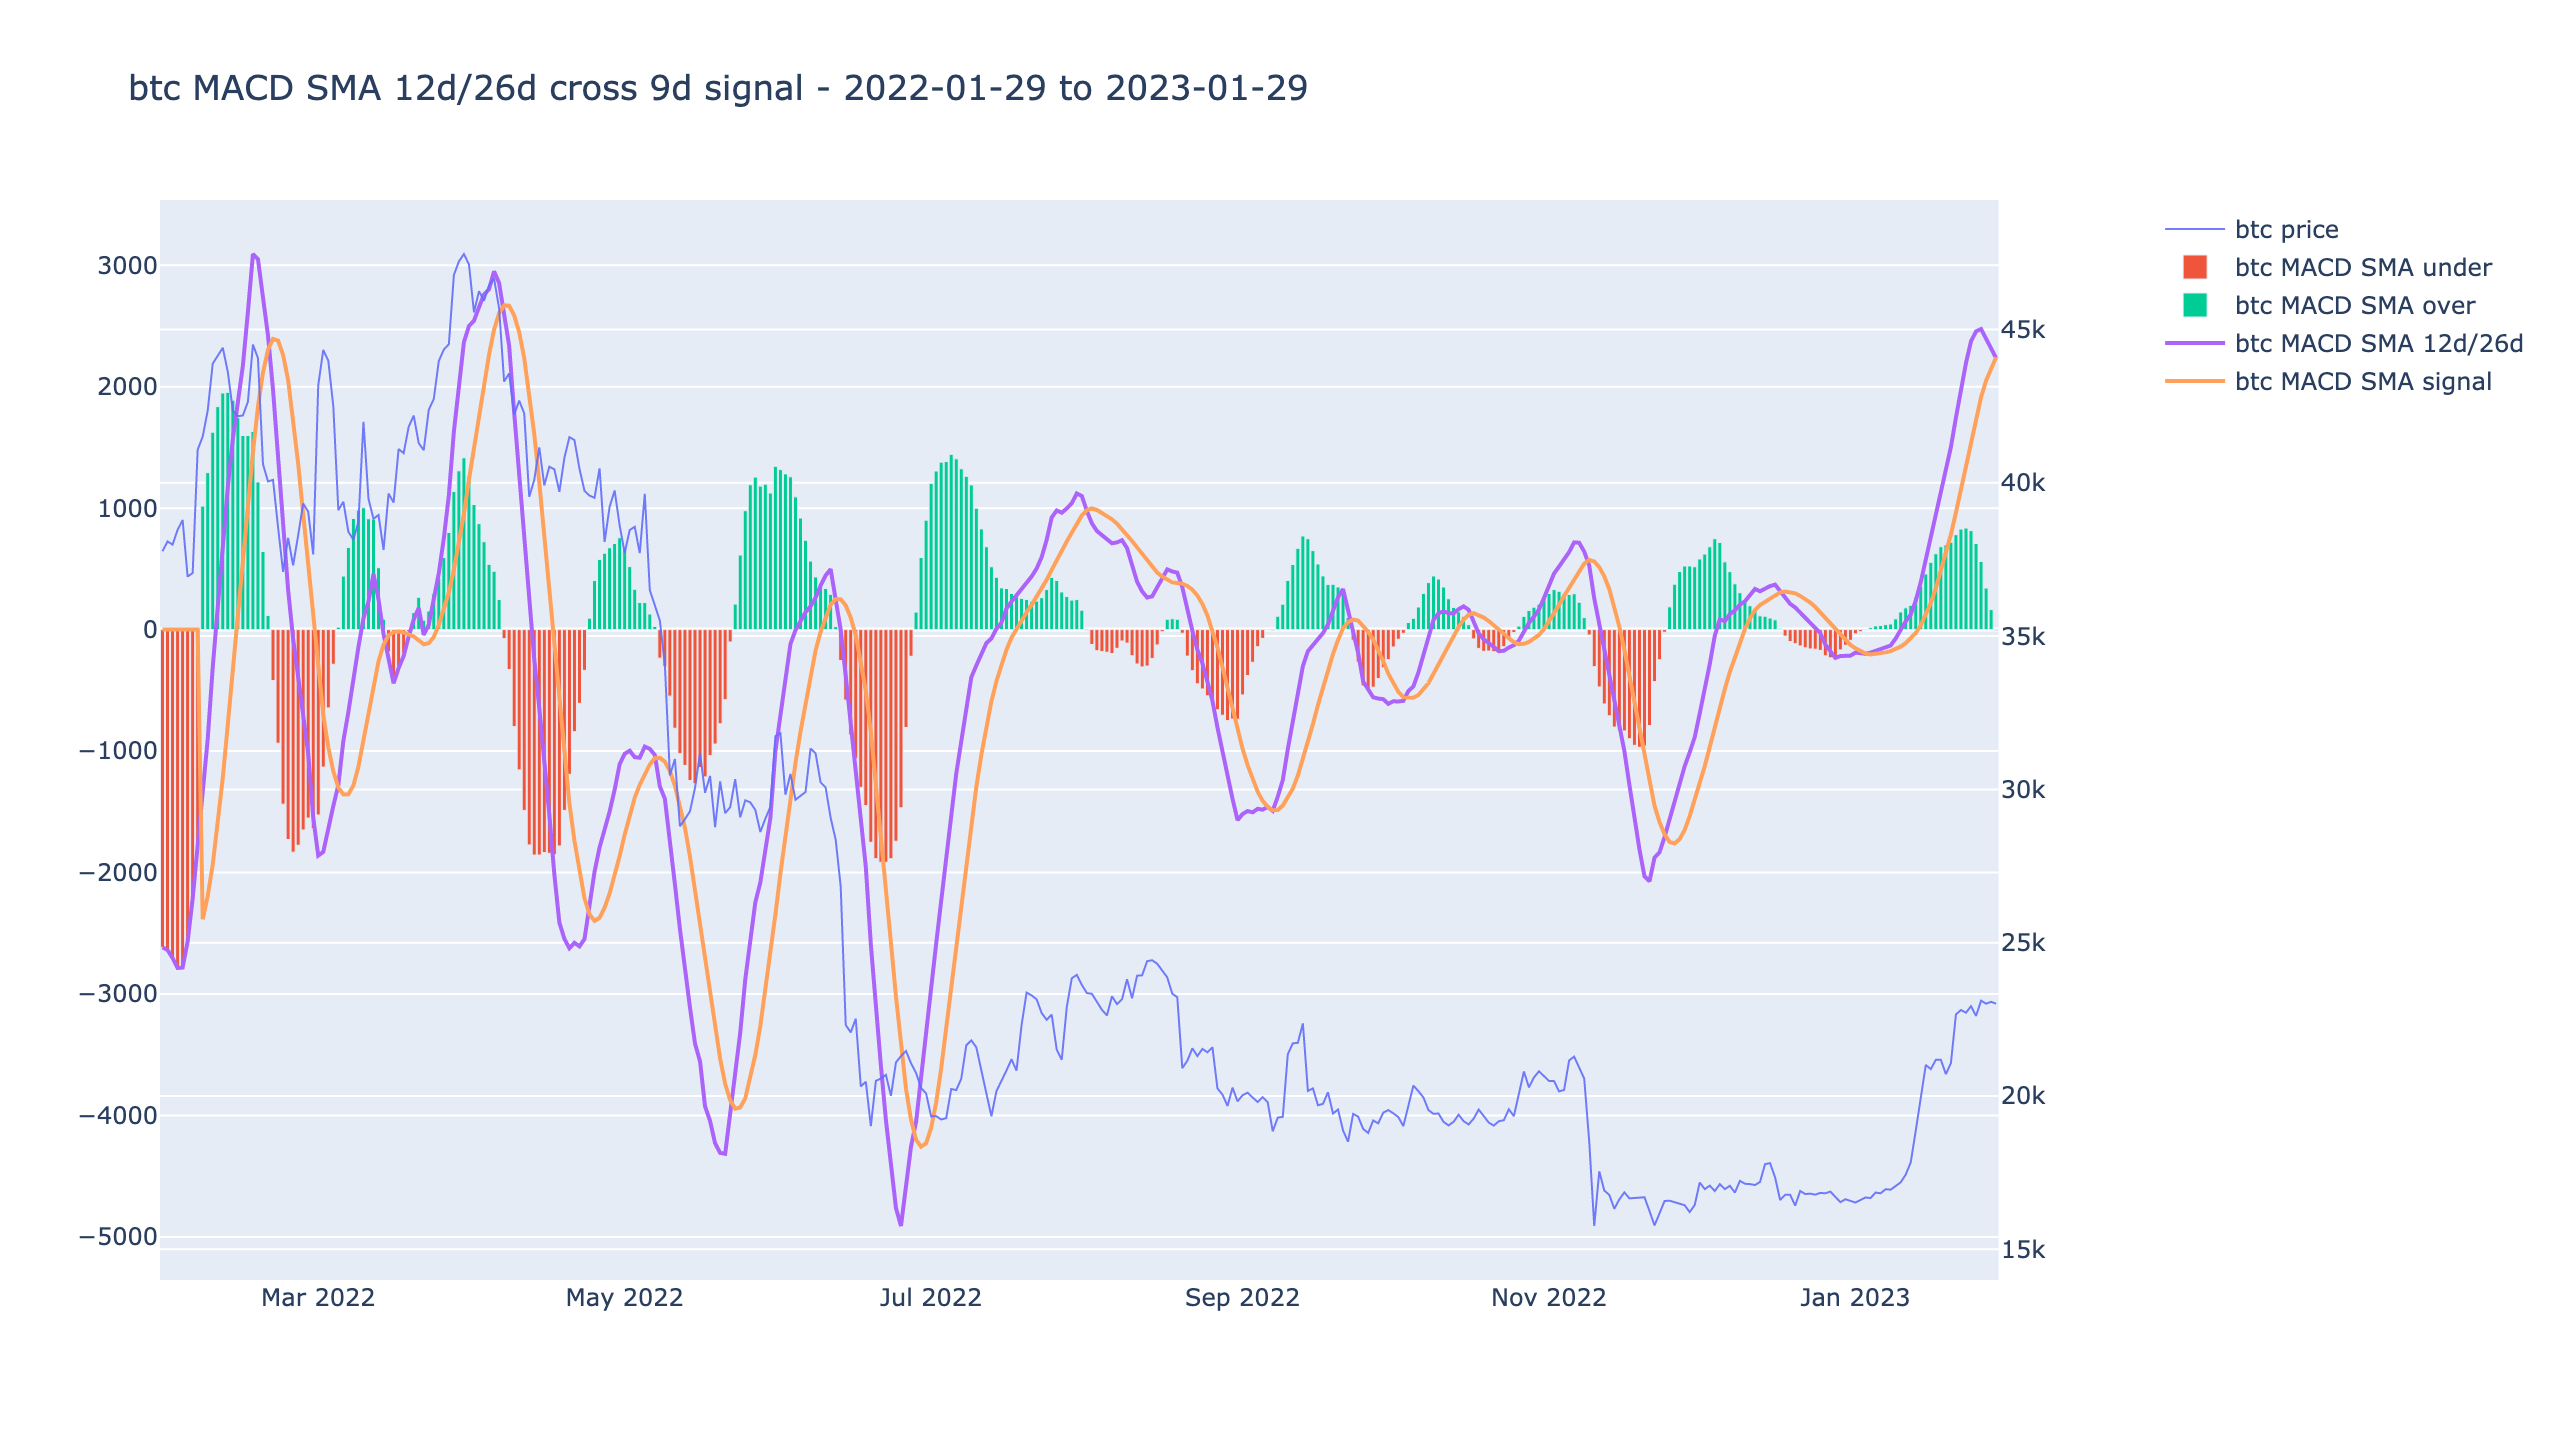

In [42]:

Image(fig_macd_sma.to_image())


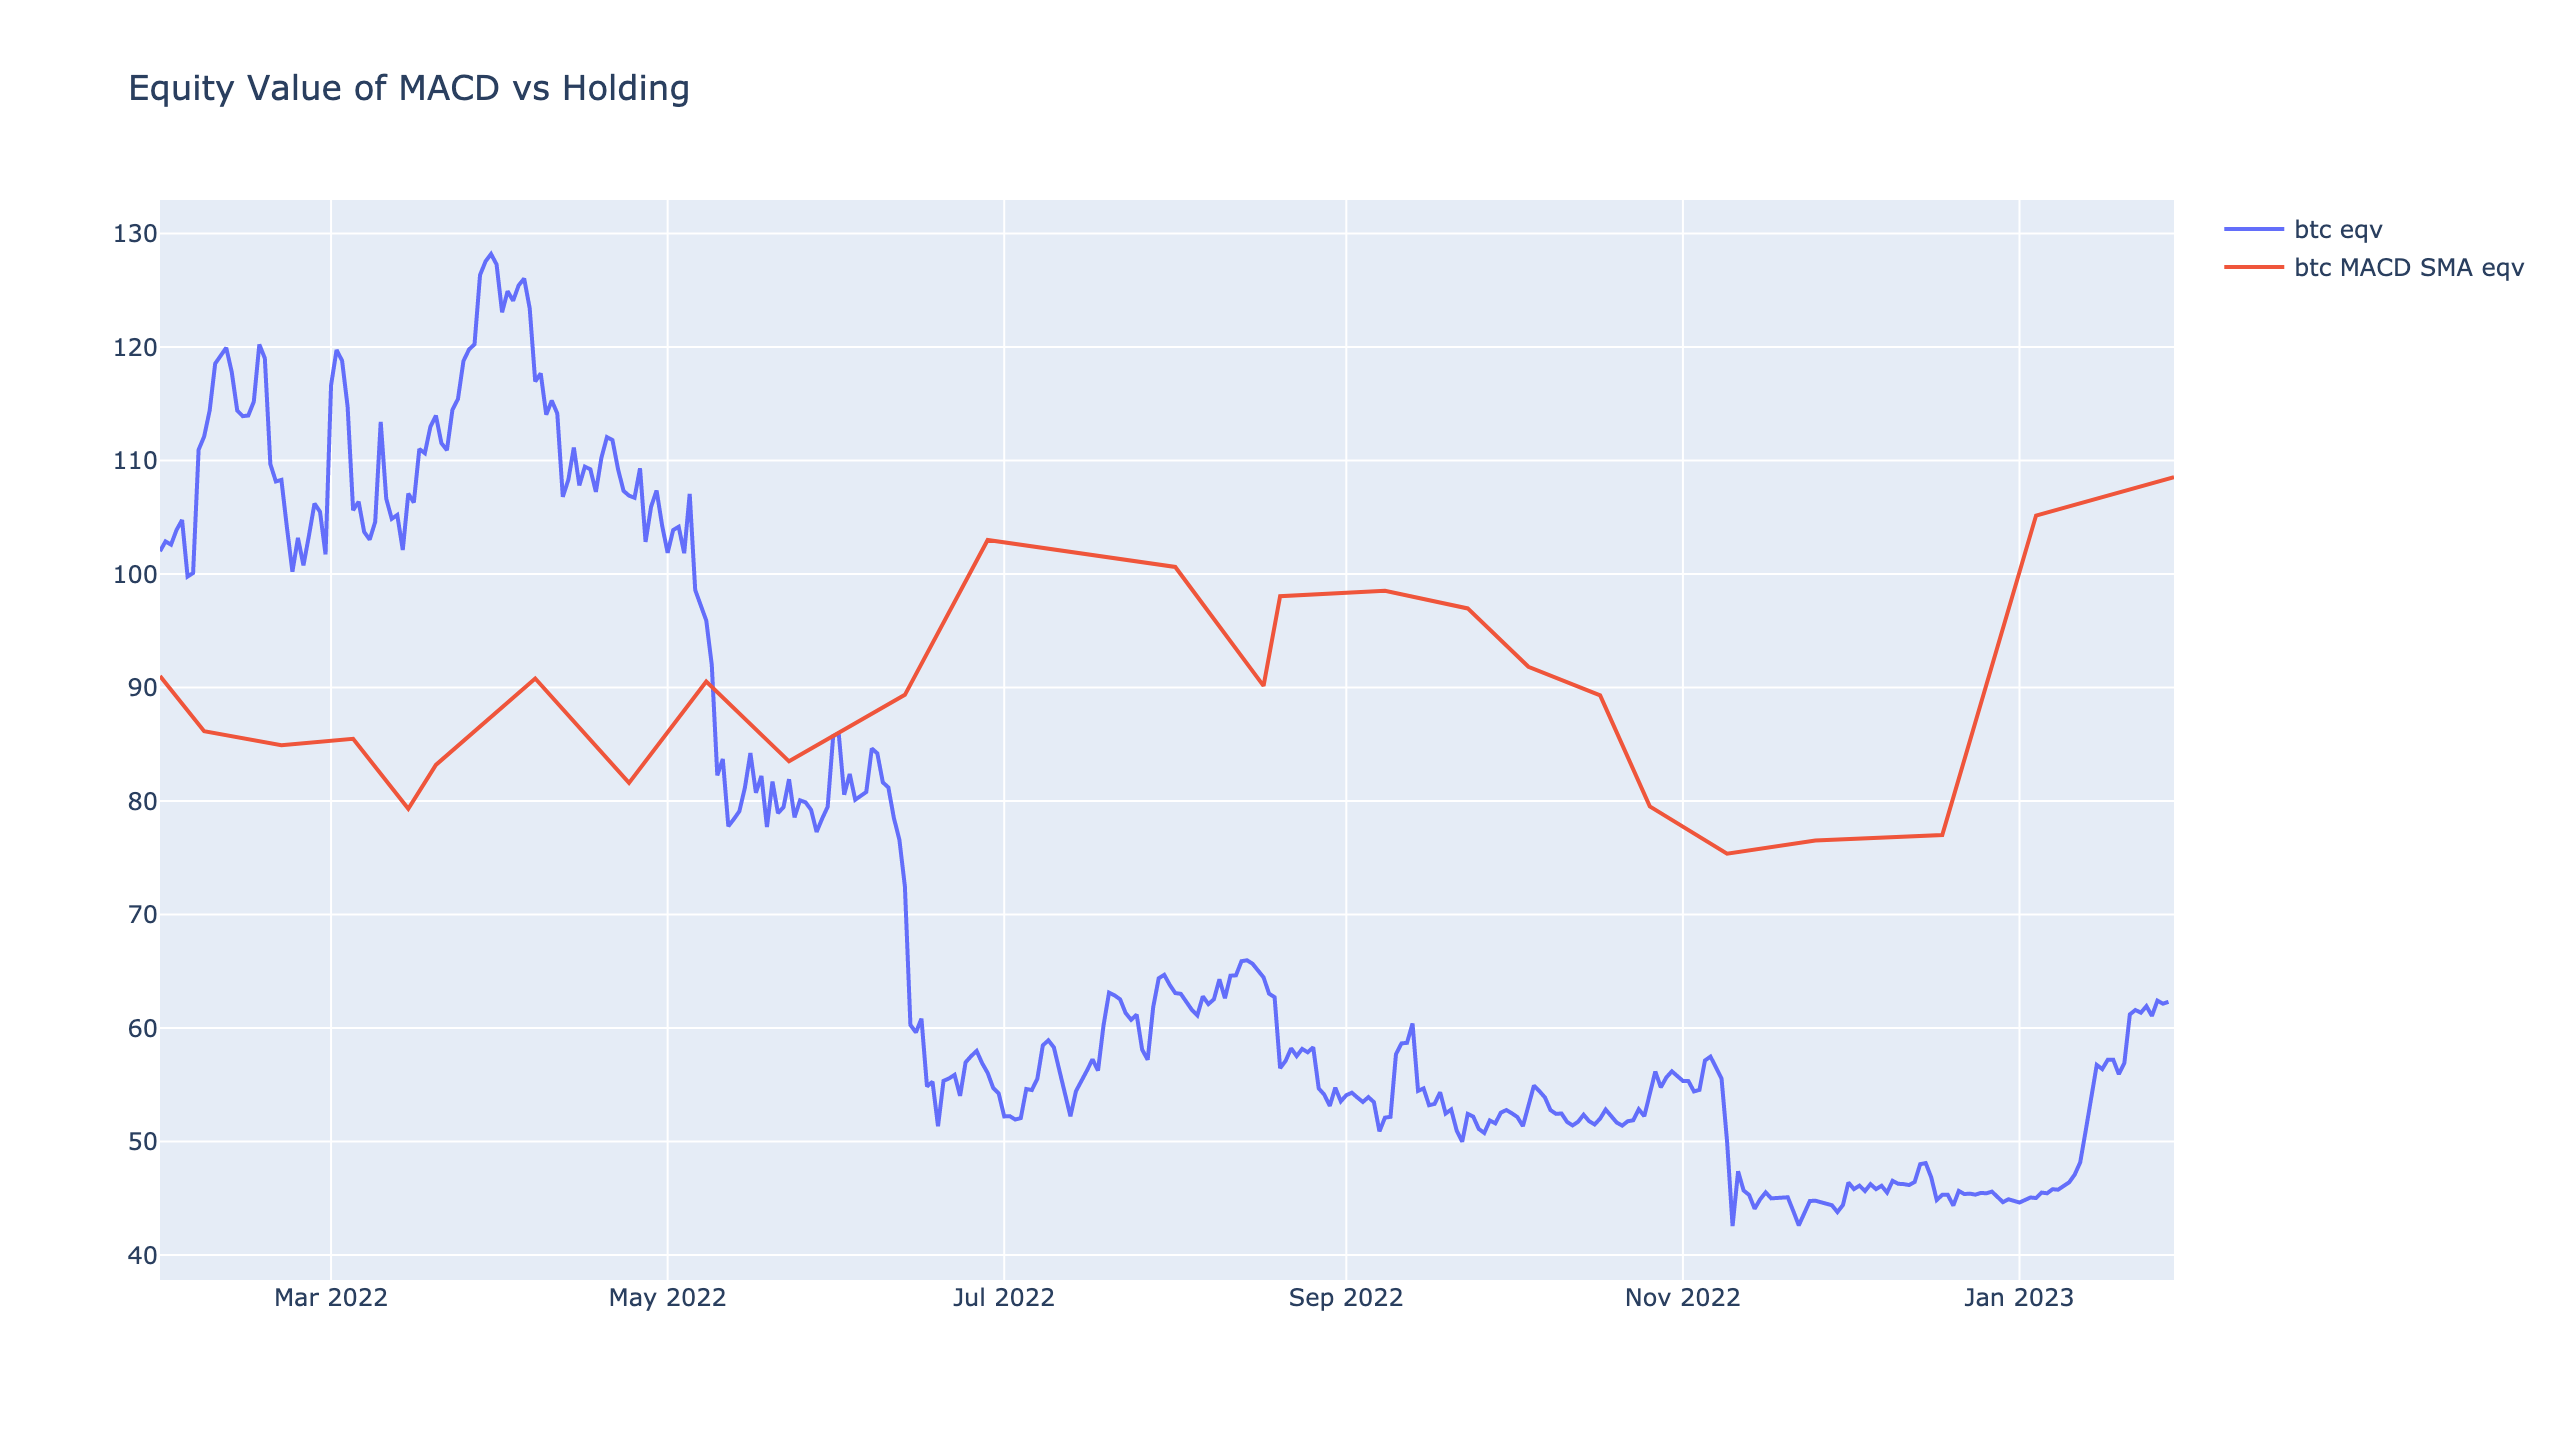

In [44]:
Image(fig_eqv.to_image())

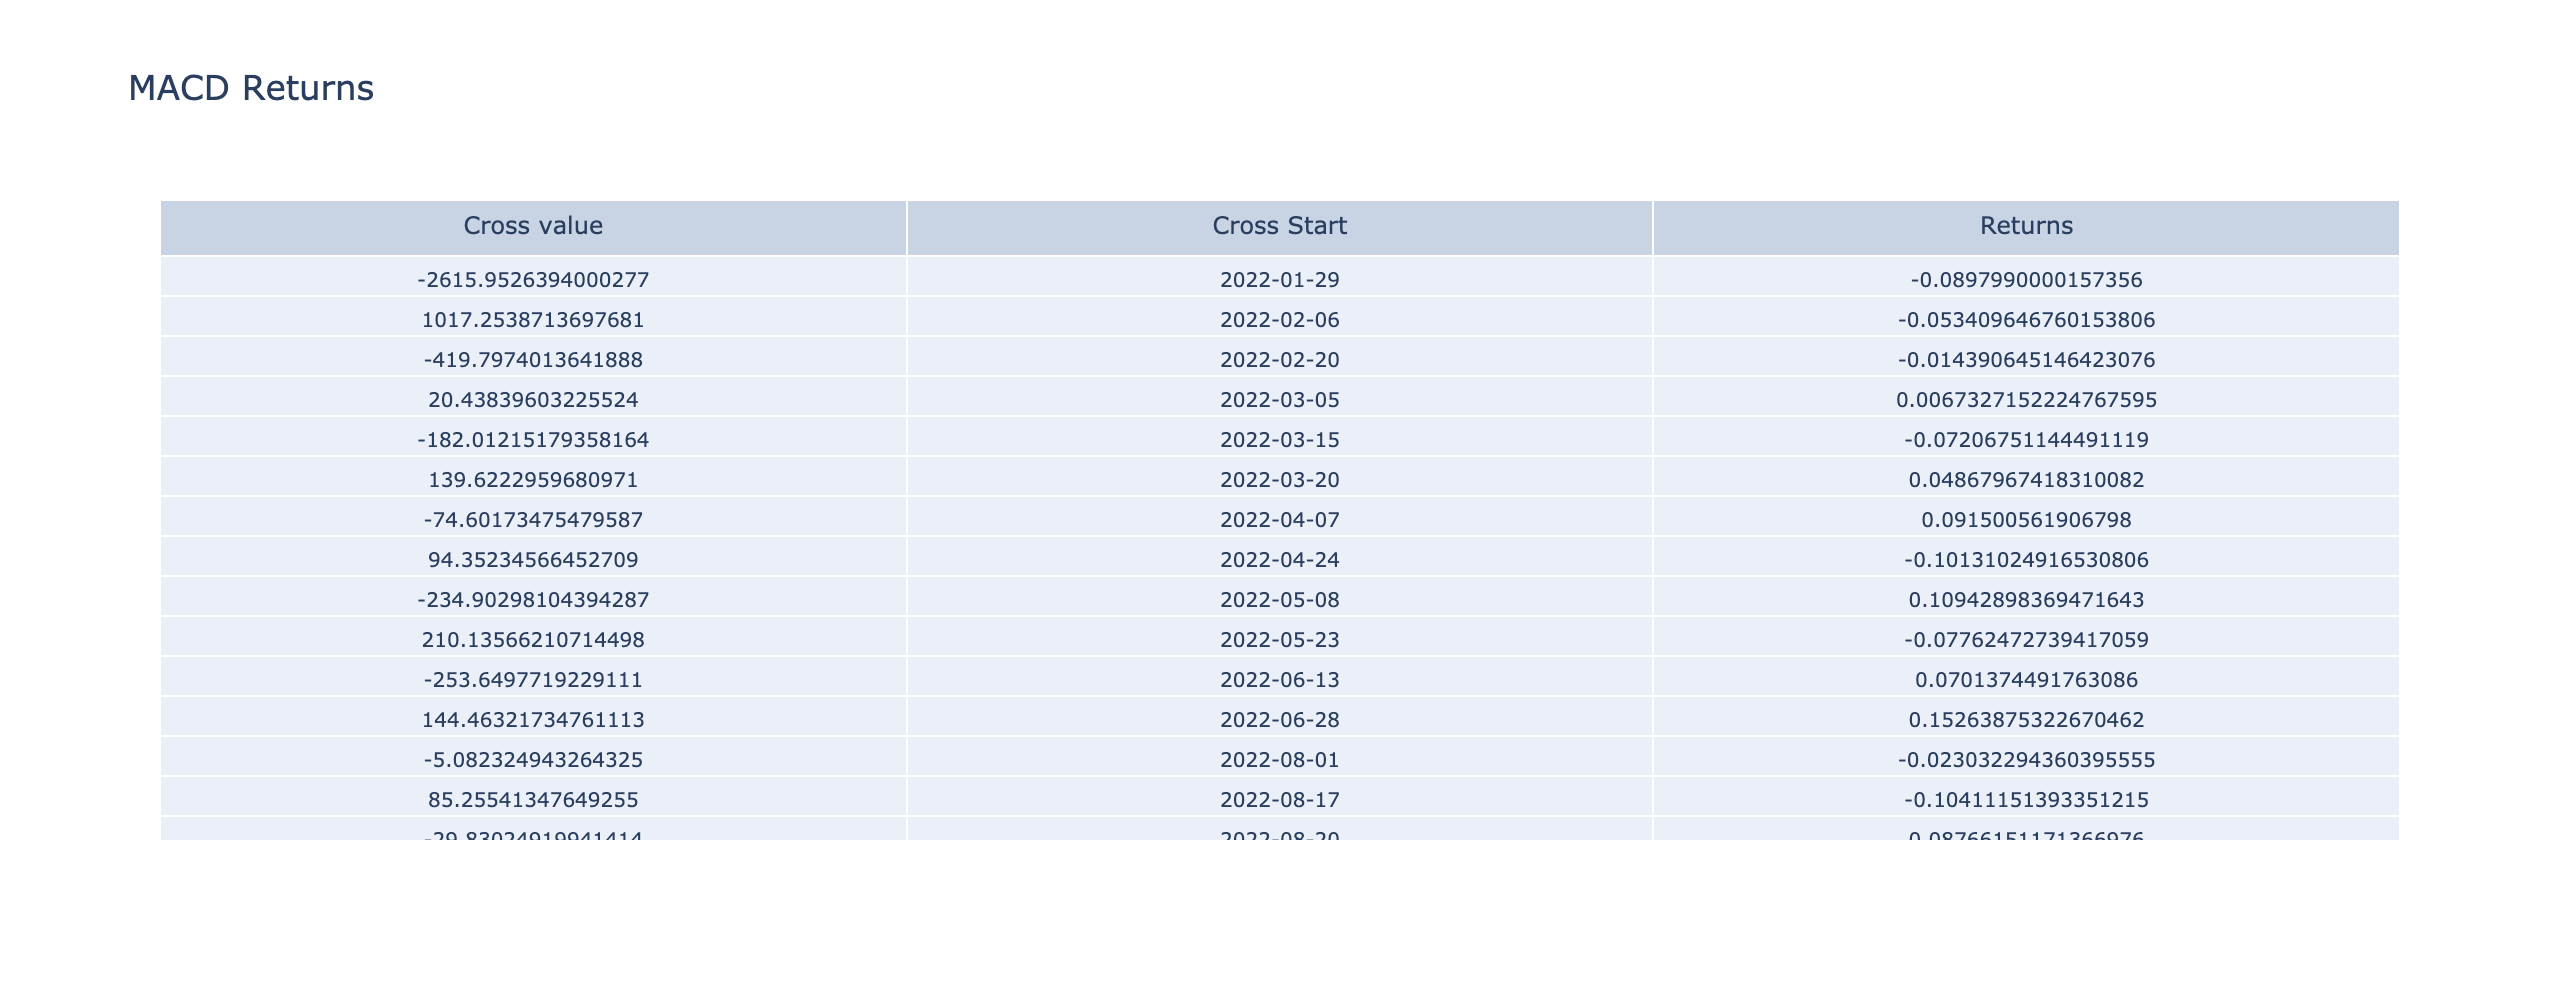

In [46]:
Image(fig_macd_sma_ret.to_image())

## Back Testing
***
Do this after 

In [23]:
train_start = '2011-01-01'
train_end = '2017-06-30'
test_start = '2017-07-01'
test_end = '2023-01-29'
trailing = [7, 14, 30, 60, 90, 180, 360]

In [24]:
coin_price['btc'].loc[train_start:train_end]

time
2011-01-01       0.300000
2011-01-02       0.300000
2011-01-03       0.299970
2011-01-04       0.295000
2011-01-05       0.298950
                 ...     
2017-06-26    2497.728941
2017-06-27    2426.365051
2017-06-28    2530.345536
2017-06-29    2562.792264
2017-06-30    2540.443032
Freq: D, Name: btc, Length: 2373, dtype: float64

In [25]:
coin_price['btc'].loc[test_start:test_end]

time
2017-07-01     2452.712064
2017-07-02     2412.366213
2017-07-03     2518.872187
2017-07-04     2551.927432
2017-07-05     2599.744750
                  ...     
2023-01-25    22611.126879
2023-01-26    23109.084519
2023-01-27    23008.689477
2023-01-28    23070.496458
2023-01-29    23008.809465
Freq: D, Name: btc, Length: 2039, dtype: float64